In [1]:
# Input (Wing data - includes geometry, flow conditions, airfoil) --------> 
# Wing models (In-built if statement depending on the data) (uses the airfoil model/spline to calculate coefficients) -------->
# Wing aerodynamic coefficients output

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler
import torch.nn.functional as F
import numpy as np
import pandas as pd
import datetime
import os
import re
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from scipy.fftpack import fft, ifft
from scipy.interpolate import CubicSpline
import joblib

ModuleNotFoundError: No module named 'torch'

In [2]:
date = datetime.date.today()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
"""
Element Spatial Convolutional Neural Network model
Number of convolutional layers - 4
Number of fully connected layers - 2
"""

# Model for lift coefficient
class ESCNN_Cl(nn.Module):
    def __init__(self):
        super(ESCNN_Cl, self).__init__()
        
        # Conv1: Assume 1D Convolution
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=200, kernel_size=5, stride=5)
        self.relu1 = nn.ReLU()

        #conv2
        self.conv2 = nn.Conv1d(in_channels=200, out_channels=200, kernel_size=1)
        self.relu2 = nn.ReLU()

        # Conv3
        self.conv3 = nn.Conv1d(in_channels=200, out_channels=100, kernel_size=1)
        self.relu3 = nn.ReLU()
        
        # Conv4
        self.conv4 = nn.Conv1d(in_channels=100, out_channels=1, kernel_size=5, padding=2)
        self.relu4 = nn.ReLU()
        
        # Final fully connected layer to output scalar
        self.fc1 = nn.Linear(in_features=34, out_features=34)
        self.relu5 = nn.ReLU()

        self.fc2 = nn.Linear(in_features=34, out_features=1)
    
    def forward(self, x):
        # Reshape input if necessary, ensure it's in the shape (batch_size, channels, elements)
        x = x.view(-1, 1, 170)  # Reshape to (batch_size, channel=1, elements=170)
        
        x = self.conv1(x)  
        x = self.relu1(x)
        
        x = self.conv2(x)  
        x = self.relu2(x)

        x = self.conv3(x)  
        x = self.relu3(x)
        
        x = self.conv4(x)  
        x = self.relu4(x)
        
        x = torch.flatten(x, 1)
        
        x = self.fc1(x)  
        x = self.relu5(x)

        x = self.fc2(x)
        
        return x



In [4]:
"""
Element Spatial Convolutional Neural Network model
Number of convolutional layers - 3
Number of fully connected layers - 2
"""

class ESCNN_Cd(nn.Module):
    def __init__(self):
        super(ESCNN_Cd, self).__init__()
        
        # Conv1: Assume 1D Convolution
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=200, kernel_size=5, stride=5)
        self.relu1 = nn.ReLU()

        #conv2
        self.conv2 = nn.Conv1d(in_channels=200, out_channels=200, kernel_size=1)
        self.relu2 = nn.ReLU()
        
        # Conv2
        self.conv3 = nn.Conv1d(in_channels=200, out_channels=1, kernel_size=5, padding=2)
        self.relu3 = nn.ReLU()
        
        # Final fully connected layer to output scalar
        self.fc1 = nn.Linear(in_features=34, out_features=34)
        self.relu4 = nn.ReLU()

        self.fc2 = nn.Linear(in_features=34, out_features=1)

        # Define learnable parameters for C_d0 and k
        self.Cd0 = nn.Parameter(torch.tensor(0.02))  # Initialized zero-lift drag coefficient
        self.k = nn.Parameter(torch.tensor(0.05))    # Initialized induced drag factor

    
    def forward(self, x):
        # Reshape input if necessary, ensure it's in the shape (batch_size, channels, elements)
        x = x.view(-1, 1, 170)  # Reshape to (batch_size, channel=1, elements=170)
        
        x = self.conv1(x)  
        x = self.relu1(x)
        
        x = self.conv2(x)  
        x = self.relu2(x)

        x = self.conv3(x)  
        x = self.relu3(x)
        
        
        x = torch.flatten(x, 1)
        
        x = self.fc1(x) 
        x = self.relu4(x)

        x = self.fc2(x)
        
        return x
    


In [5]:
# Initialize airfoil model (Use the saved trained model)

# Cl Model
class RBFLayer_cl(nn.Module):
    def __init__(self, in_features, out_features, centers=None):
        super(RBFLayer_cl, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        
        # Centers initialized using KMeans or passed explicitly
        if centers is None:
            self.centers = nn.Parameter(torch.Tensor(out_features, in_features))
            nn.init.uniform_(self.centers, -1, 1)  # Random if not initialized with KMeans
        else:
            self.centers = nn.Parameter(torch.Tensor(centers))  # Set centers from KMeans
        
        # Initialize the beta (width) parameter, positive constraint with softplus
        self.log_beta = nn.Parameter(torch.ones(out_features) * torch.log(torch.tensor(0.1)))

    @property
    def beta(self):
        # Ensures beta is positive using softplus
        return F.softplus(self.log_beta)
    
    def forward(self, input):
        # Compute distances between inputs and centers
        x = input.unsqueeze(1).expand(-1, self.out_features, self.in_features)
        c = self.centers.unsqueeze(0).expand(input.size(0), -1, -1)
        
        # Squared Euclidean distance
        distances = torch.sum((x - c) ** 2, dim=-1).to(device)
        
        # Apply Gaussian RBF
        return torch.exp(-self.beta.unsqueeze(0) * distances)

class RBFNet_cl(nn.Module):
    def __init__(self, input_size, rbf_units, output_size, centers=None):
        super(RBFNet_cl, self).__init__()
        self.rbf = RBFLayer_cl(input_size, rbf_units, centers)
        self.fc = nn.Linear(rbf_units, output_size)
        
        # Initialize weights for the linear layer
        nn.init.xavier_uniform_(self.fc.weight)
        nn.init.zeros_(self.fc.bias)
        
    def forward(self, x):
        rbf_out = self.rbf(x)
        return self.fc(rbf_out)

# Cd Model
class RBFLayer_cd(nn.Module):
    def __init__(self, in_features, out_features, centers=None):
        super(RBFLayer_cd, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        
        # Centers initialized using KMeans or passed explicitly
        if centers is None:
            self.centers = nn.Parameter(torch.Tensor(out_features, in_features))
            nn.init.uniform_(self.centers, -1, 1)  # Random if not initialized with KMeans
        else:
            self.centers = nn.Parameter(torch.Tensor(centers))  # Set centers from KMeans
        
        # Initialize the beta (width) parameter, positive constraint with softplus
        self.log_beta = nn.Parameter(torch.ones(out_features) * torch.log(torch.tensor(18.2)))

    @property
    def beta(self):
        # Ensures beta is positive using softplus
        return F.softplus(self.log_beta)
    
    def forward(self, input):
        # Compute distances between inputs and centers
        x = input.unsqueeze(1).expand(-1, self.out_features, self.in_features)
        c = self.centers.unsqueeze(0).expand(input.size(0), -1, -1)
        
        # Squared Euclidean distance
        distances = torch.sum((x - c) ** 2, dim=-1).to(device)
        
        # Apply Gaussian RBF
        return torch.exp(-self.beta.unsqueeze(0) * distances)

class RBFNet_cd(nn.Module):
    def __init__(self, input_size, rbf_units, output_size, centers=None):
        super(RBFNet_cd, self).__init__()
        self.rbf = RBFLayer_cd(input_size, rbf_units, centers)
        self.fc = nn.Linear(rbf_units, output_size)
        
        # Initialize weights for the linear layer
        nn.init.xavier_uniform_(self.fc.weight)
        nn.init.zeros_(self.fc.bias)
        
    def forward(self, x):
        rbf_out = self.rbf(x)
        return self.fc(rbf_out)
     


In [6]:
# Load the model weights
af_model_ESCNN_Cl = ESCNN_Cl()
af_model_ESCNN_Cl.load_state_dict(torch.load('/mnt/e/Course_Materials/ROM/airfoil_model/trained_models_Cl/2024-11-18_model_Cl_ESCNN_lr1e-05_e1500_rbf170_convL4.pth'))
af_model_ESCNN_Cl = af_model_ESCNN_Cl.to(device)
af_model_ESCNN_Cl.eval()

# Load the model weights
af_model_ESCNN_Cd = ESCNN_Cd()
af_model_ESCNN_Cd.load_state_dict(torch.load('/mnt/e/Course_Materials/ROM/airfoil_model/trained_model_cd/2024-11-18_model_Cd_ESCNN_lr5e-05_e250_convL3.pth'))
af_model_ESCNN_Cd = af_model_ESCNN_Cd.to(device)
af_model_ESCNN_Cd.eval()



input_size = 140
output_size = 4
num_rbf_units = 4

kmeans_center_cl = torch.load('/mnt/e/Course_Materials/ROM/wing_model/wing_section/trained_models/2024-11-19_airfoil_model_Cl_ESCNN_RBF_lr0.06_epoch200_rbfUnits4_RBFcenters.pth')
kmeans_center_cd = torch.load('/mnt/e/Course_Materials/ROM/wing_model/wing_section/trained_models/2024-11-19_airfoil_model_Cd_ESCNN_RBF_lr0.025_epoch100_rbfUnits4_RBFcenters.pth')


class airfoilModel_cl(RBFNet_cl):
    def __init__(self):
        super(airfoilModel_cl, self).__init__(input_size, num_rbf_units, output_size, kmeans_center_cl)


class airfoilModel_cd(RBFNet_cd):
    def __init__(self):
        super(airfoilModel_cd, self).__init__(input_size, num_rbf_units, output_size, kmeans_center_cd)


# Initialize the model
airfoil_cl = airfoilModel_cl()
airfoil_cl.load_state_dict(torch.load('/mnt/e/Course_Materials/ROM/wing_model/wing_section/trained_models/2024-11-19_airfoil_model_Cl_ESCNN_RBF_lr0.06_epoch200_rbfUnits4.pth'))

airfoil_cd = airfoilModel_cd()
airfoil_cd.load_state_dict(torch.load('/mnt/e/Course_Materials/ROM/wing_model/wing_section/trained_models/2024-11-19_airfoil_model_Cd_ESCNN_RBF_lr0.025_epoch100_rbfUnits4.pth'))

airfoil_cl = airfoil_cl.to(device)
airfoil_cd = airfoil_cd.to(device)

airfoil_cl.eval()
airfoil_cd.eval()

/tmp/ipykernel_70019/3261372605.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  af_model_ESCNN_Cl.load_state_dict(torch.load('/mnt/e/Course_Materials/ROM/airfoil_model/t

airfoilModel_cd(
  (rbf): RBFLayer_cd()
  (fc): Linear(in_features=4, out_features=4, bias=True)
)

In [7]:
# Prepare the airfoil data 

# Downsampling using average pooling
"""
Downsample the input array to 35 elements using interpolation.
"""

def downsample_to_35(input_array):
    input_tensor = torch.tensor(input_array, dtype=torch.float32)
    
    # Reshape the input to be 1D (if it's not already)
    if input_tensor.dim() == 1:
        input_tensor = input_tensor.unsqueeze(0).unsqueeze(0)  # Shape (1, 1, original_length)
    elif input_tensor.dim() == 2:
        input_tensor = input_tensor.unsqueeze(0)  # Shape (1, original_channels, original_length)
    
    # Perform interpolation to downsample to 35 elements
    downsampled_tensor = F.interpolate(input_tensor, size=35, mode='linear', align_corners=True)
    
    # Remove the unnecessary dimensions to return a 1D tensor
    downsampled_array = downsampled_tensor.squeeze().numpy()
    
    return downsampled_array

def prep_data(root, keyword=None):

    # Initialization of arrays
    # Coordinates
    x_i = [] # Initial coordinates - before downsizing
    y_i = []

    # Polars
    alphas = []
    Cls = []
    Cds = []
    Cms = []

    if keyword:
        # lists of files in each dir
        coord_files = [f for f in os.listdir(root) if f == (keyword+'_coordinates.dat')]
        polar_files = [f for f in os.listdir(root) if f == ('xf-'+keyword+'-il-1000000.csv')]
    else:
        # lists of files in each dir
        coord_files = [f for f in os.listdir(root) if f.endswith('_coordinates.dat')]
        polar_files = [f for f in os.listdir(root) if f.endswith('.csv')]

    # Extract base names from coordinate files
    coord_bases = {re.sub(r'\_coordinates.dat$', '', f) for f in coord_files}
    polar_bases = {}
    for polar_file in polar_files:
        match = re.match(r'xf-(.*)-il-1000000\.csv$', polar_file)
        if match:
            base_name = match.group(1)
            polar_bases[base_name] = polar_file
    # print(polar_bases)
    for base_name in coord_bases:
        if base_name in polar_bases:
            coord_file = f"{base_name}_coordinates.dat"
            polar_file = polar_bases[base_name]

            coordinate_data = np.loadtxt(root+coord_file)
            # polar_data = np.loadtxt(root+polar_file, skiprows=12)
            polar_data = pd.read_csv(root+polar_file, skiprows=10)
            polar_data = polar_data[(polar_data['Alpha'] >= -2) & (polar_data['Alpha'] <= 12)]
            # print(len(polar_data))

            # Coordinates
            x = []
            y = []

            # Polars
            alpha = polar_data['Alpha'].values
            Cl = polar_data['Cl'].values
            Cd = polar_data['Cd'].values
            # Cm = polar_data['Cm'].values

            # print(alpha)

            for i in range(0, len(coordinate_data)):
                np.array(x.append(float(coordinate_data[i][0]))) 
                np.array(y.append(float(coordinate_data[i][1])))
                
            if len(x) == 35:    # Only consider the files with more than 35 coordinates
                x_i.append(x)
                y_i.append(y)

                alphas.append(alpha)
                Cls.append(Cl)
                Cds.append(Cd)
            elif len(x) > 35:    # If there are more than 35 coordinates, downsample it to 35.
                x_i.append(downsample_to_35(x))
                y_i.append(downsample_to_35(y))

                alphas.append(alpha)
                Cls.append(Cl)
                Cds.append(Cd)

                # for num_val in range(len(Cl)):
                #     Cls.append(Cl[num_val])
                #     Cds.append(Cd[num_val])
                #     Cms.append(Cm[num_val])

    return x_i, y_i, Cls, Cds, alphas

"""
Create the dataset
Arange the input data in columns [x, y, alpha (AOA), Re, M]
"""
def organize_data(x_f, y_f, alphas):

    Elements = []

    # Loop through the polars
    for n_file in range(len(x_f)):
        x_temp = x_f[n_file]
        y_temp = y_f[n_file]
        alpha_temp = alphas[n_file]
        
        for j in range(len(alpha_temp)):
            batch = []
            # Loop through the coodrinates
            for i in range(len(x_temp)-1):
                element = np.array([x_temp[i], y_temp[i], x_temp[i+1], y_temp[i+1], alpha_temp[j]])
                batch.append(element)
            batch = np.array(batch)
            batch = batch.flatten()
            Elements.append(batch)

    Elements = np.array(Elements)

    return Elements

1
Input Cl shape:  (1, 140)
Input Cd shape:  (1, 140)
Target Cl shape:  (1, 4)
Target Cd shape:  (1, 4)
1
Input Cl shape:  (1, 140)
Input Cd shape:  (1, 140)
Target Cl shape:  (1, 4)
Target Cd shape:  (1, 4)
1
Input Cl shape:  (1, 140)
Input Cd shape:  (1, 140)
Target Cl shape:  (1, 4)
Target Cd shape:  (1, 4)
1
Input Cl shape:  (1, 140)
Input Cd shape:  (1, 140)
Target Cl shape:  (1, 4)
Target Cd shape:  (1, 4)
1
Input Cl shape:  (1, 140)
Input Cd shape:  (1, 140)
Target Cl shape:  (1, 4)
Target Cd shape:  (1, 4)
1
Input Cl shape:  (1, 140)
Input Cd shape:  (1, 140)
Target Cl shape:  (1, 4)
Target Cd shape:  (1, 4)
1
Input Cl shape:  (1, 140)
Input Cd shape:  (1, 140)
Target Cl shape:  (1, 4)
Target Cd shape:  (1, 4)
0
1
Input Cl shape:  (1, 140)
Input Cd shape:  (1, 140)
Target Cl shape:  (1, 4)
Target Cd shape:  (1, 4)
1
Input Cl shape:  (1, 140)
Input Cd shape:  (1, 140)
Target Cl shape:  (1, 4)
Target Cd shape:  (1, 4)
1
Input Cl shape:  (1, 140)
Input Cd shape:  (1, 140)
Target C

/tmp/ipykernel_70019/4014334444.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(15, 5))


Input Cl shape:  (1, 140)
Input Cd shape:  (1, 140)
Target Cl shape:  (1, 4)
Target Cd shape:  (1, 4)
0
1
Input Cl shape:  (1, 140)
Input Cd shape:  (1, 140)
Target Cl shape:  (1, 4)
Target Cd shape:  (1, 4)
1
Input Cl shape:  (1, 140)
Input Cd shape:  (1, 140)
Target Cl shape:  (1, 4)
Target Cd shape:  (1, 4)
1
Input Cl shape:  (1, 140)
Input Cd shape:  (1, 140)
Target Cl shape:  (1, 4)
Target Cd shape:  (1, 4)
1
Input Cl shape:  (1, 140)
Input Cd shape:  (1, 140)
Target Cl shape:  (1, 4)
Target Cd shape:  (1, 4)
0
1
Input Cl shape:  (1, 140)
Input Cd shape:  (1, 140)
Target Cl shape:  (1, 4)
Target Cd shape:  (1, 4)


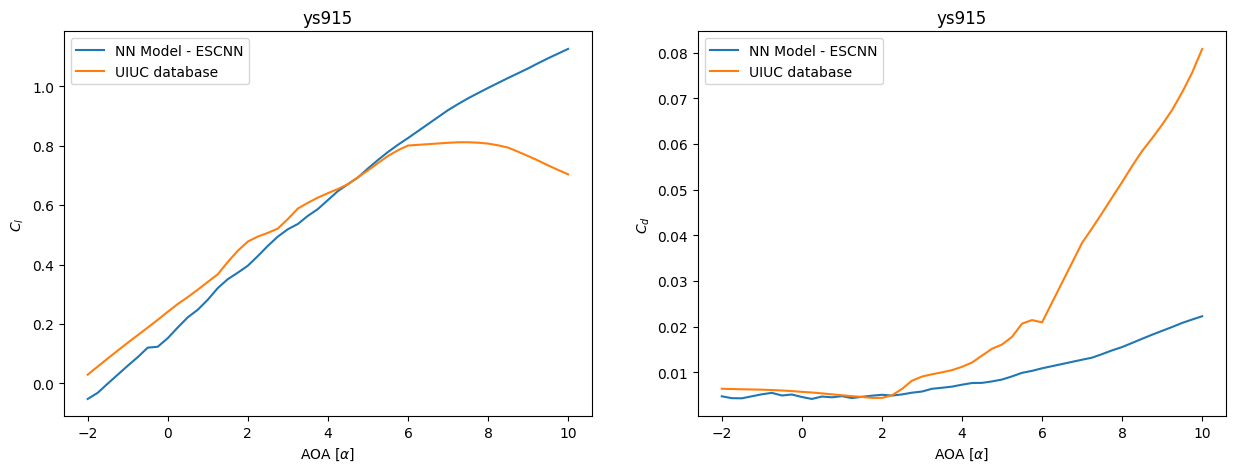

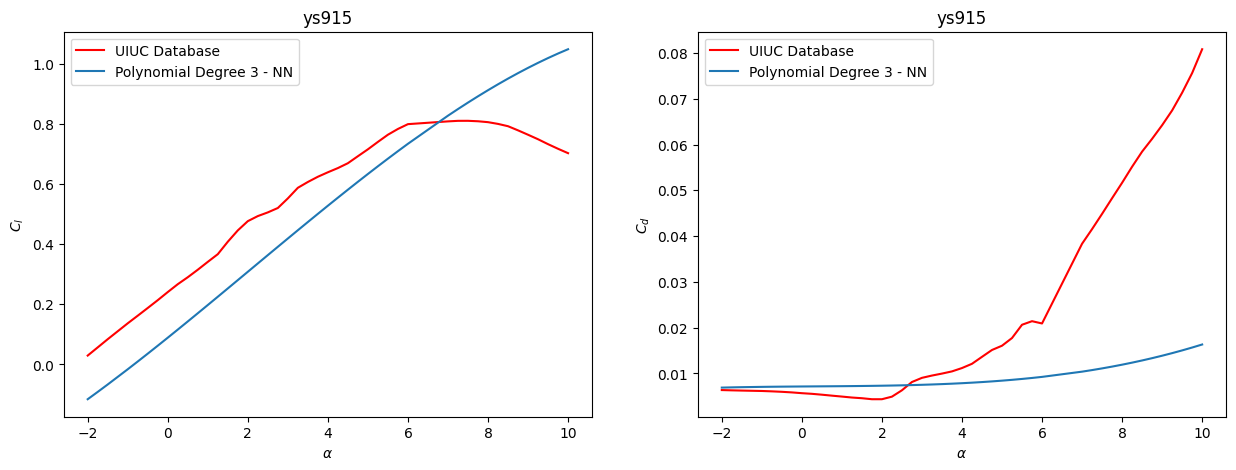

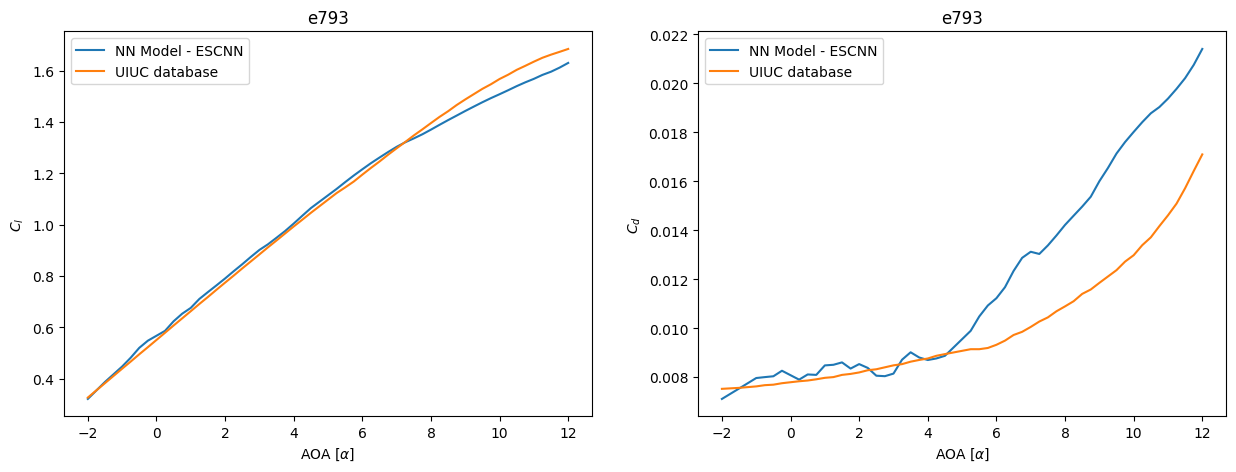

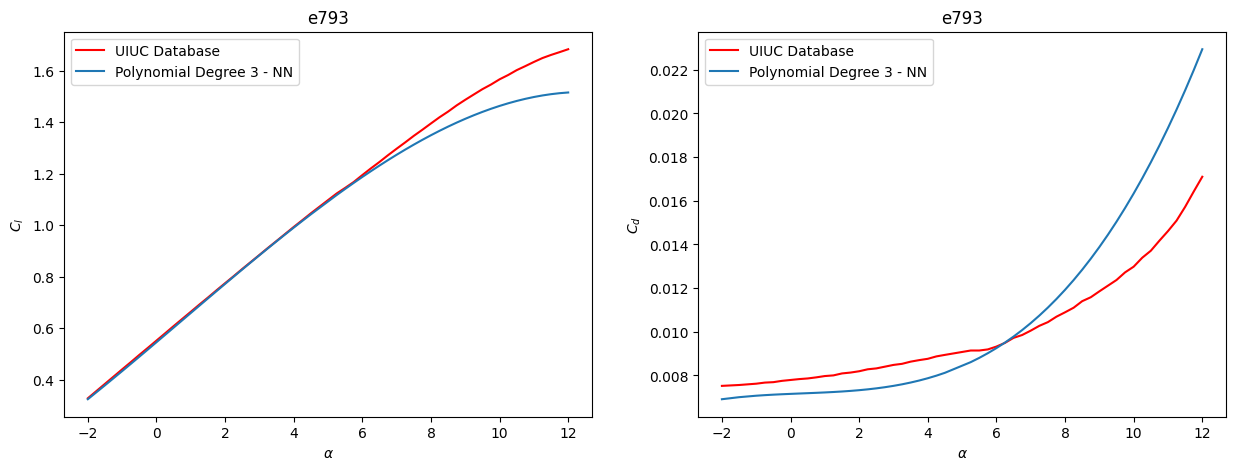

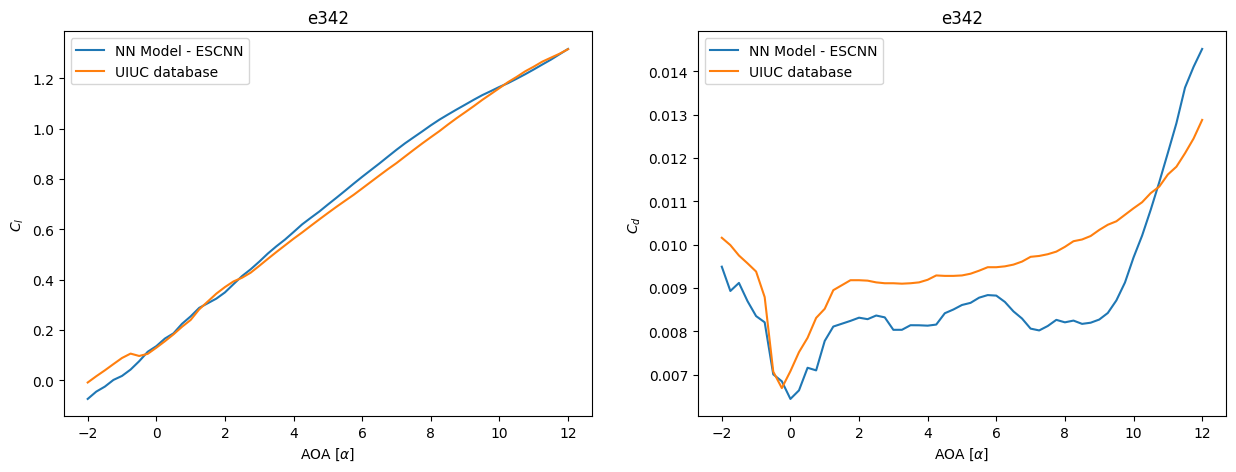

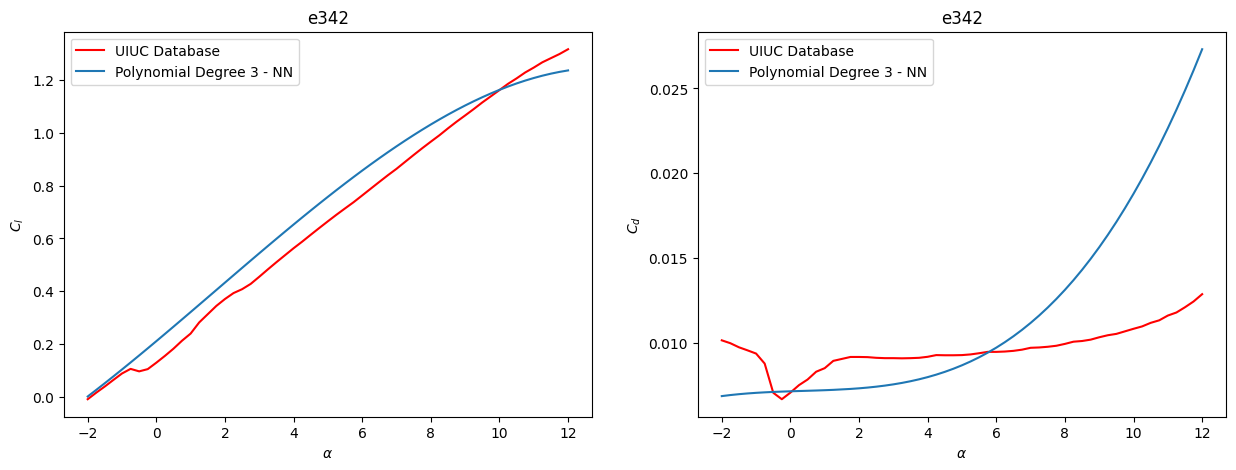

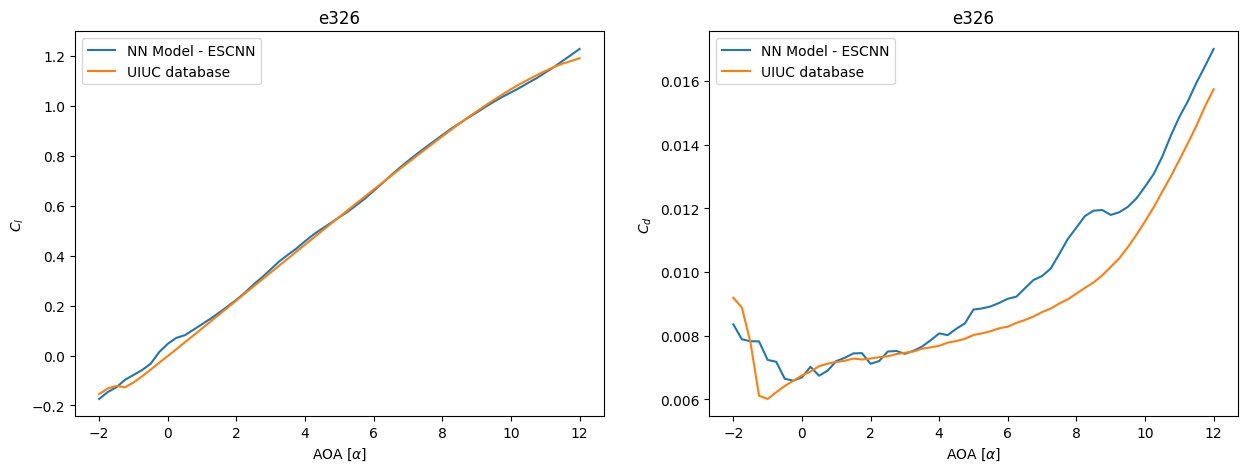

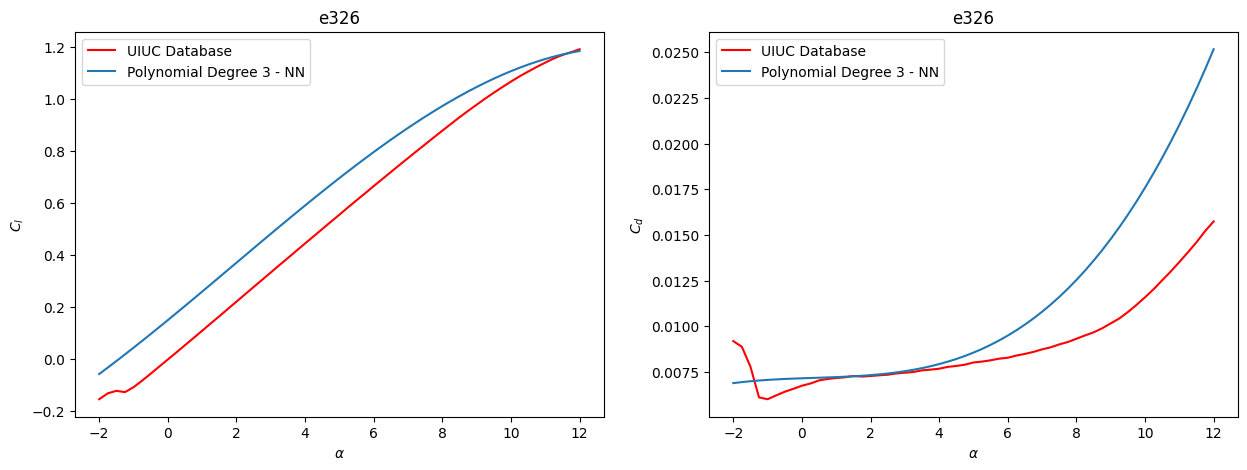

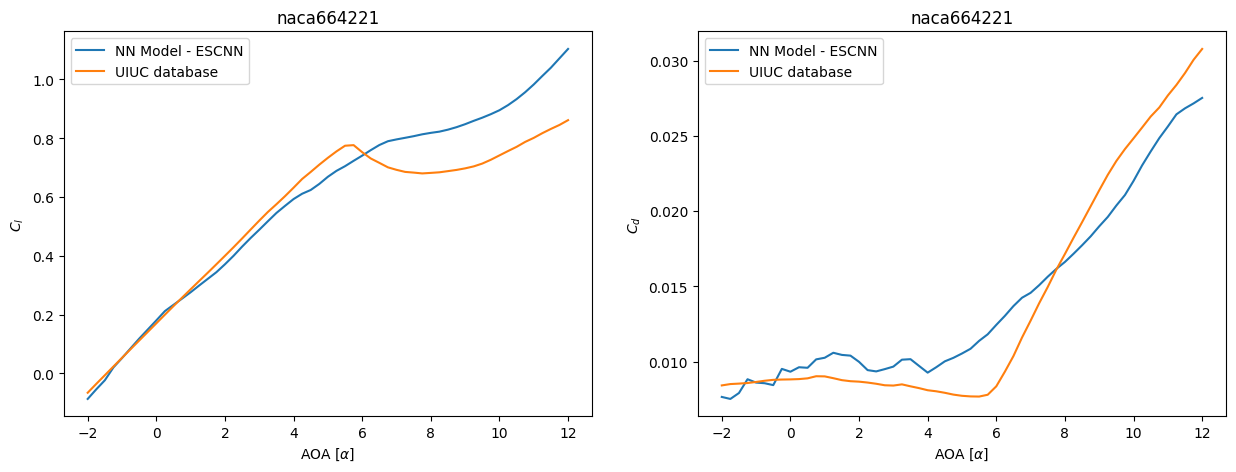

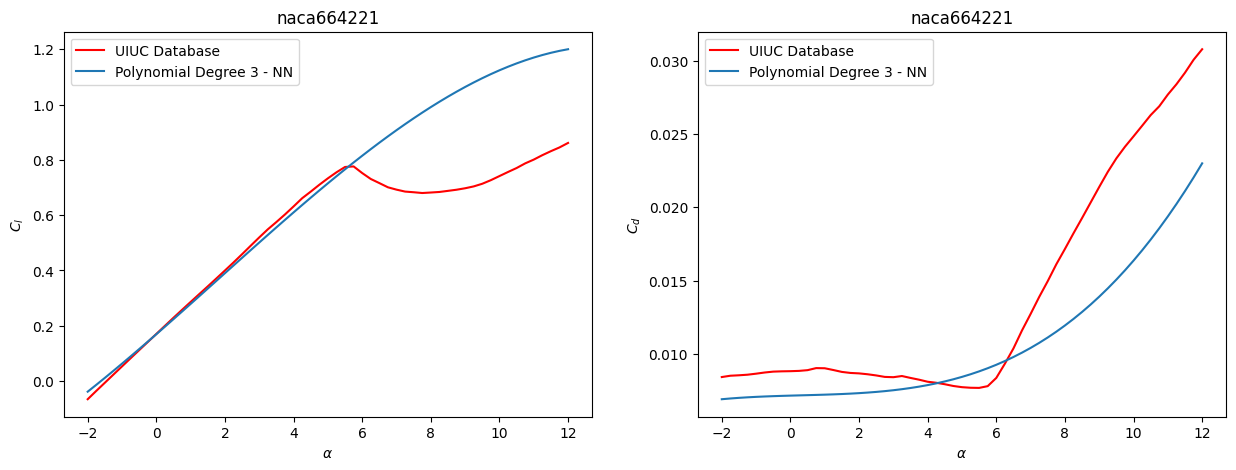

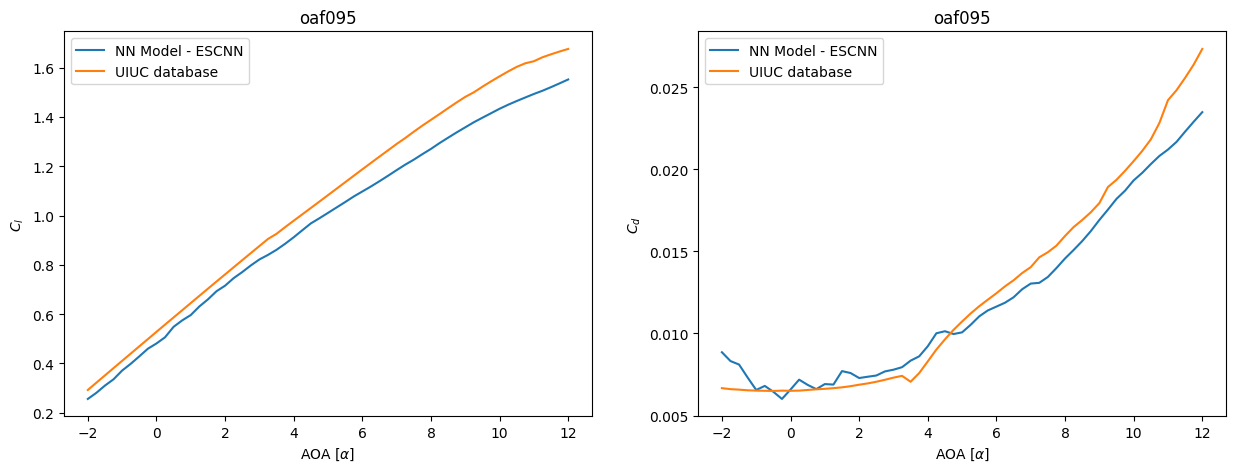

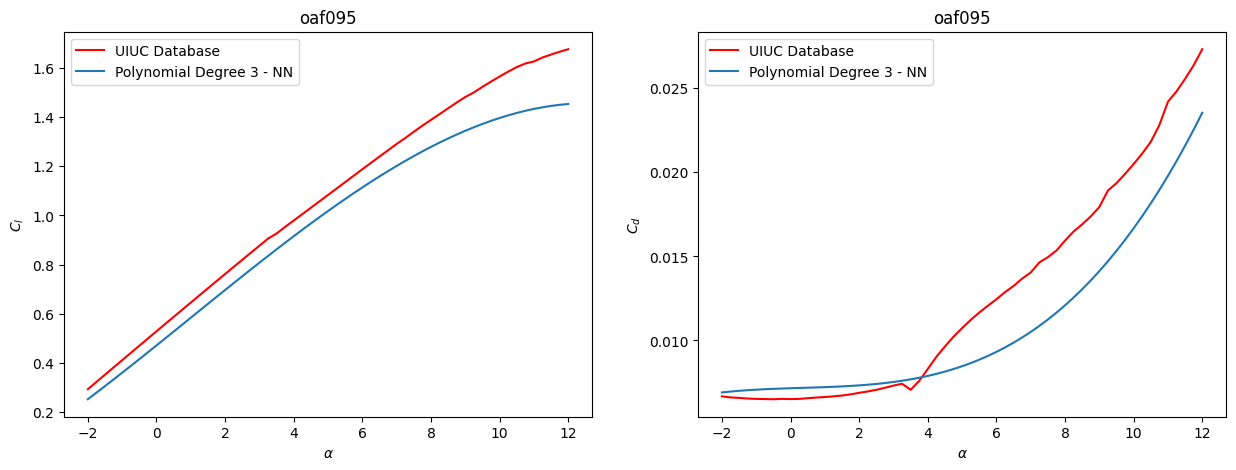

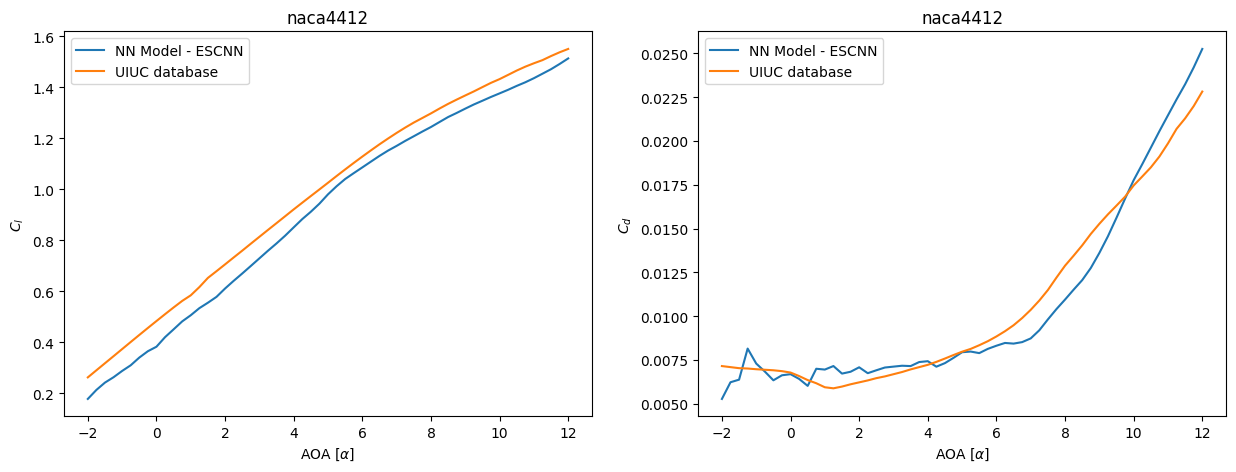

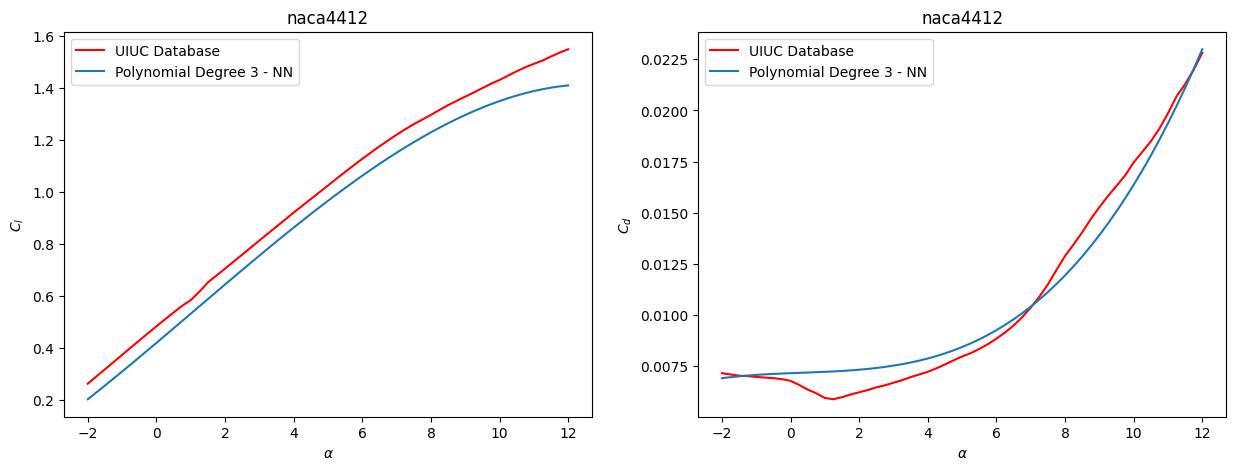

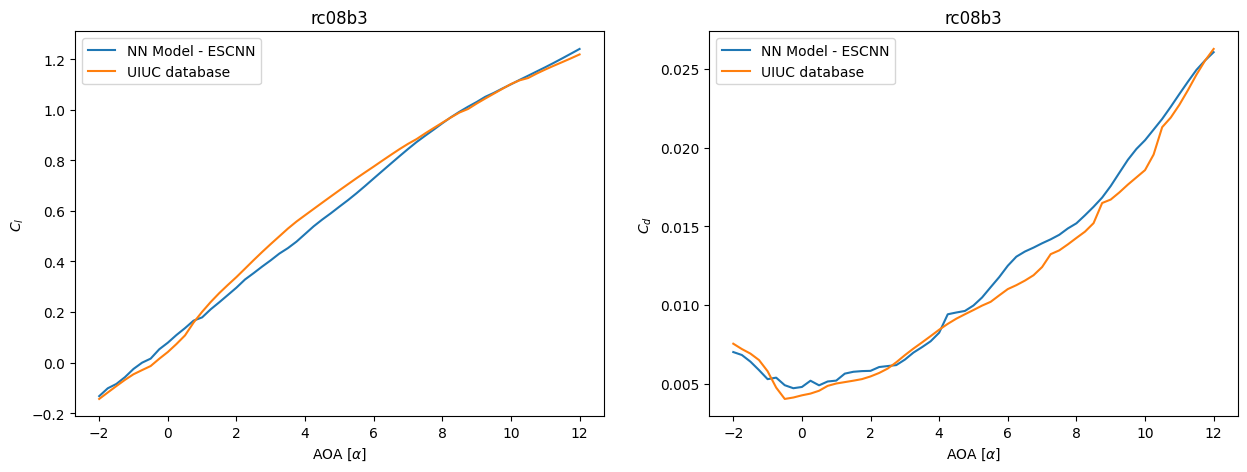

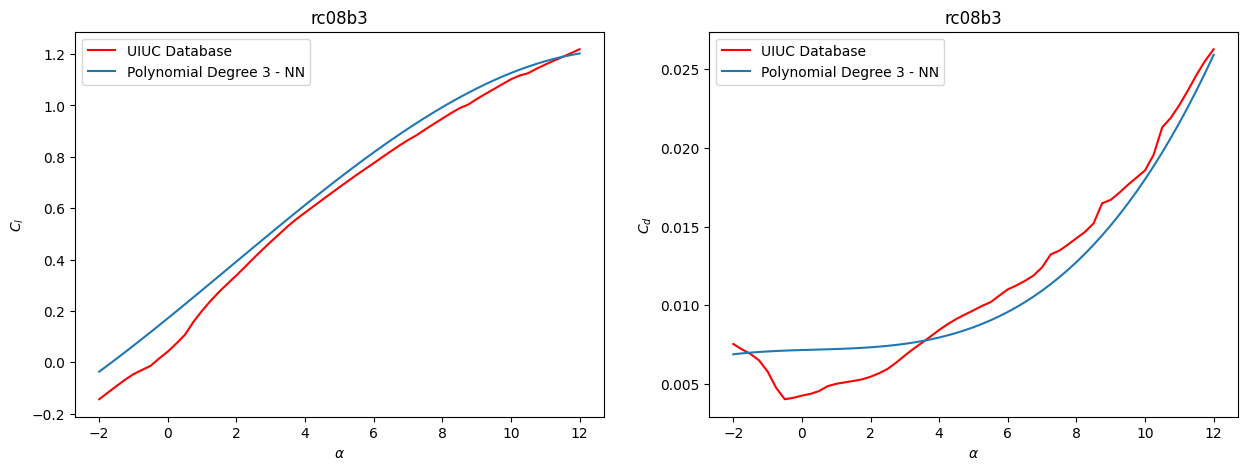

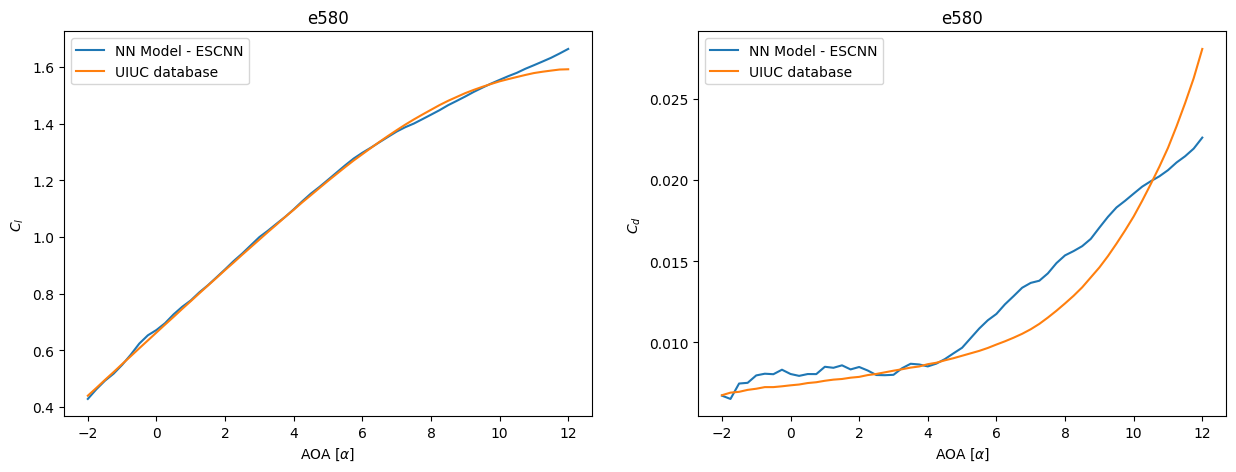

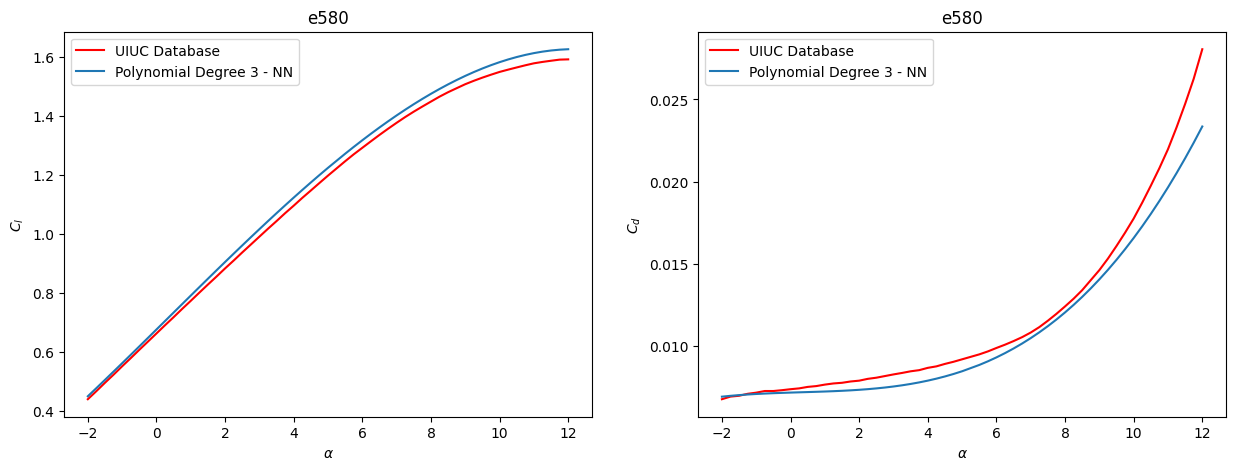

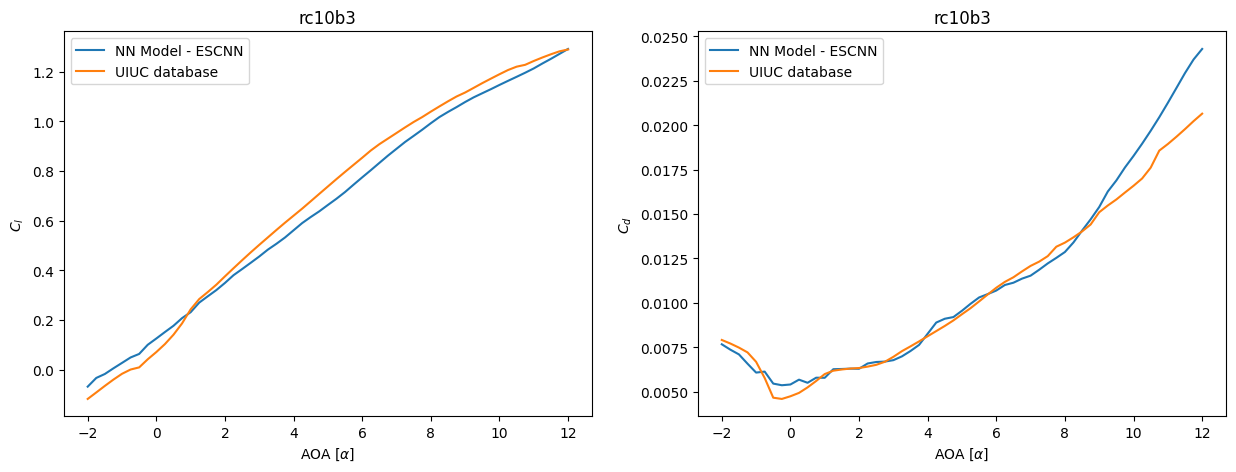

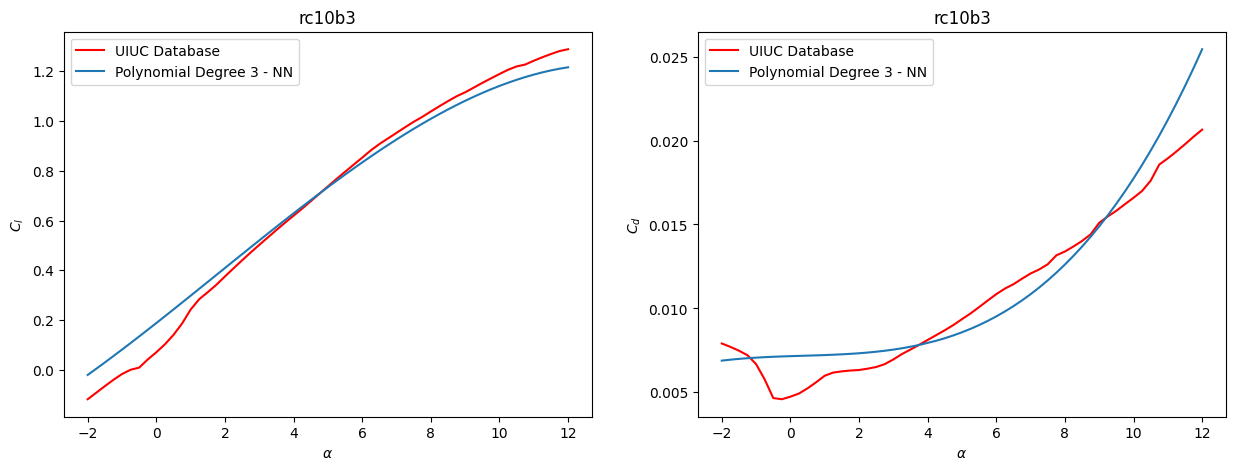

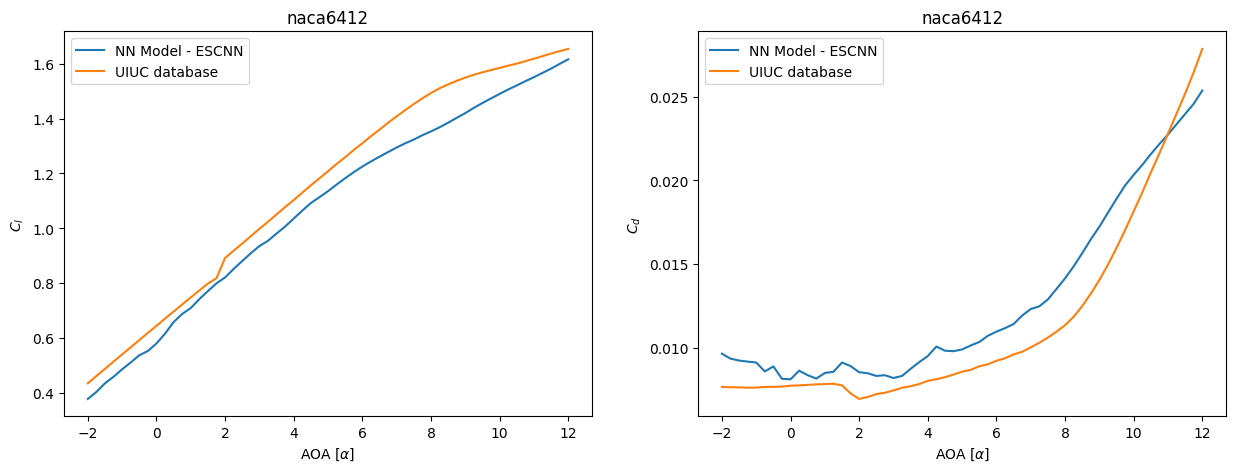

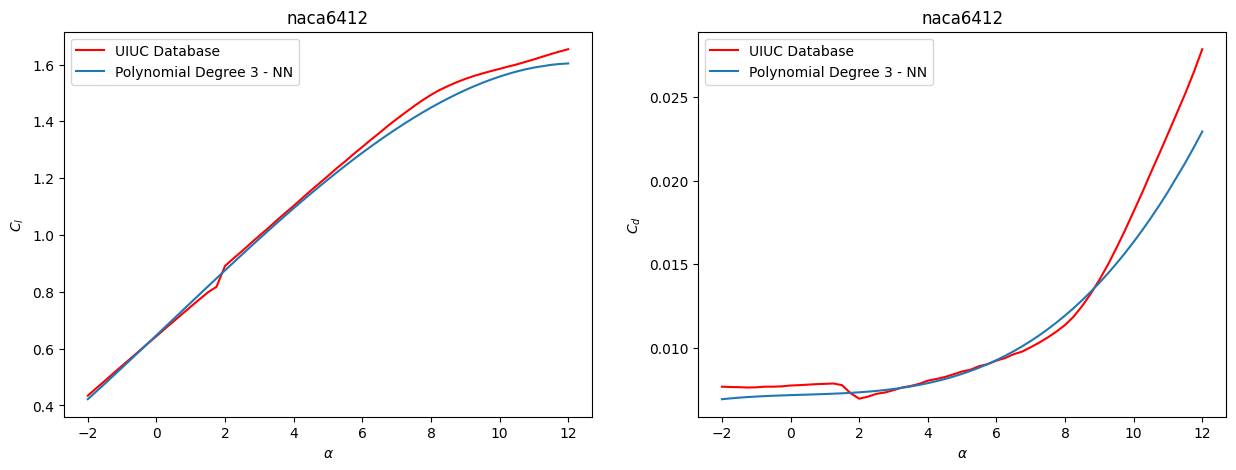

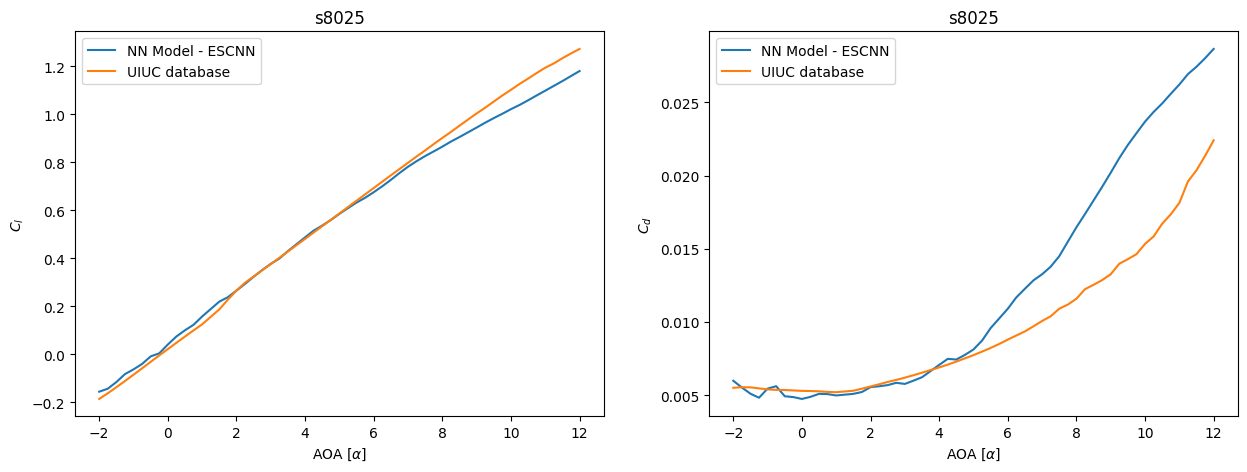

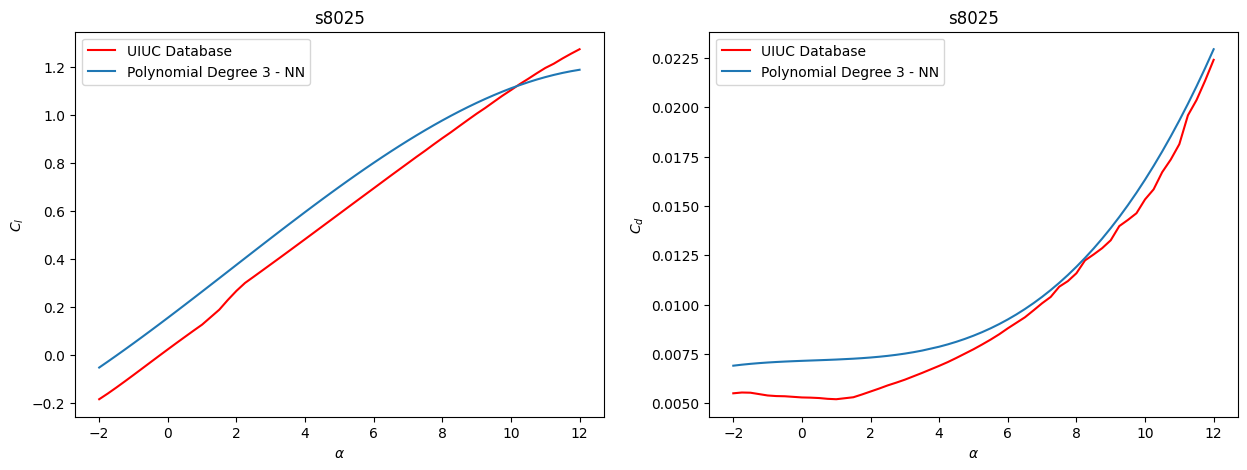

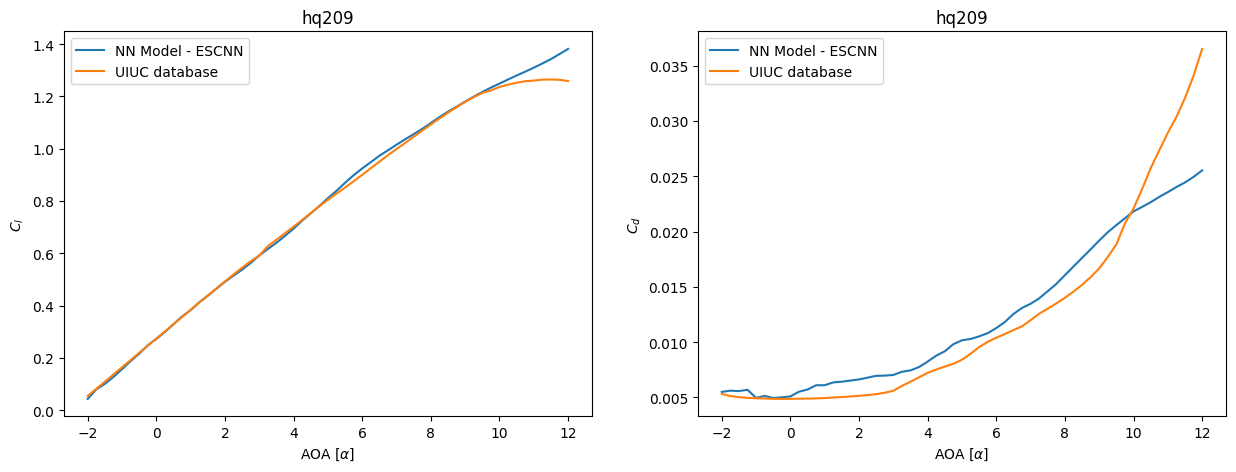

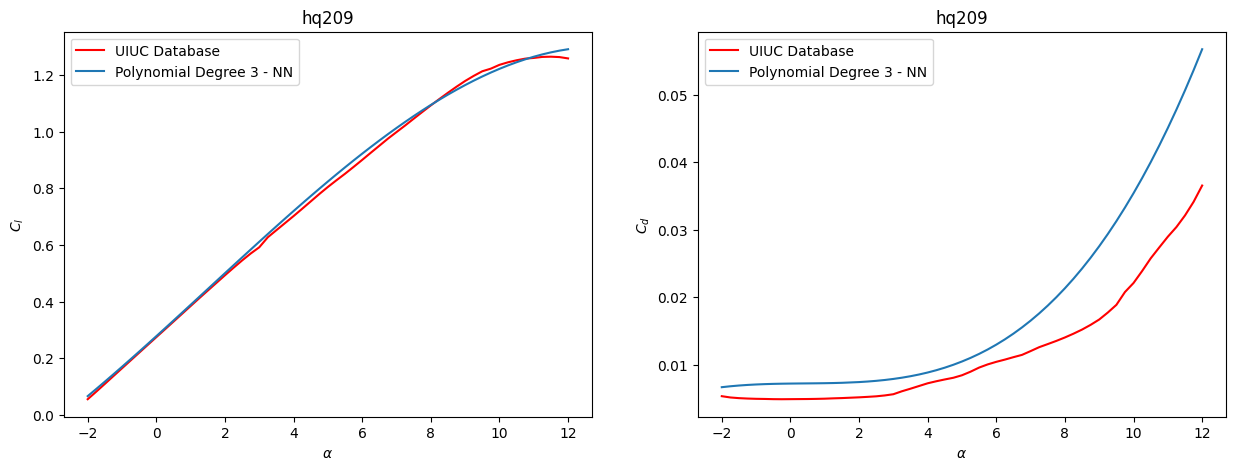

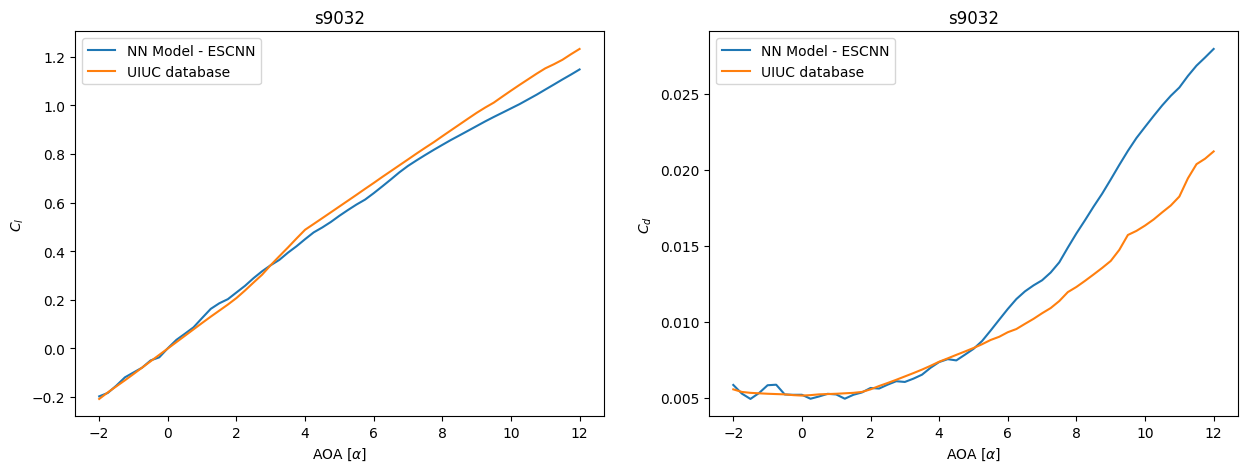

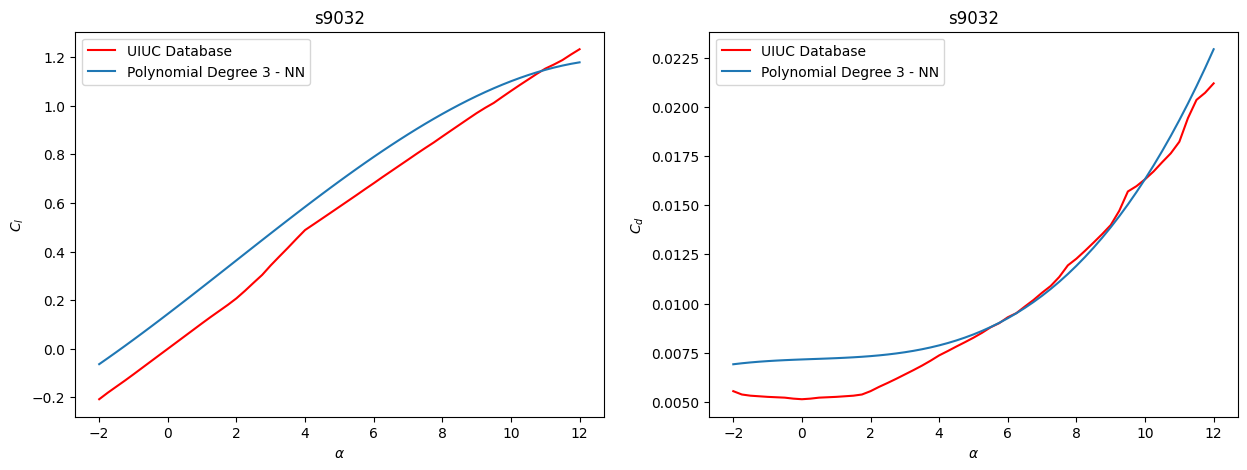

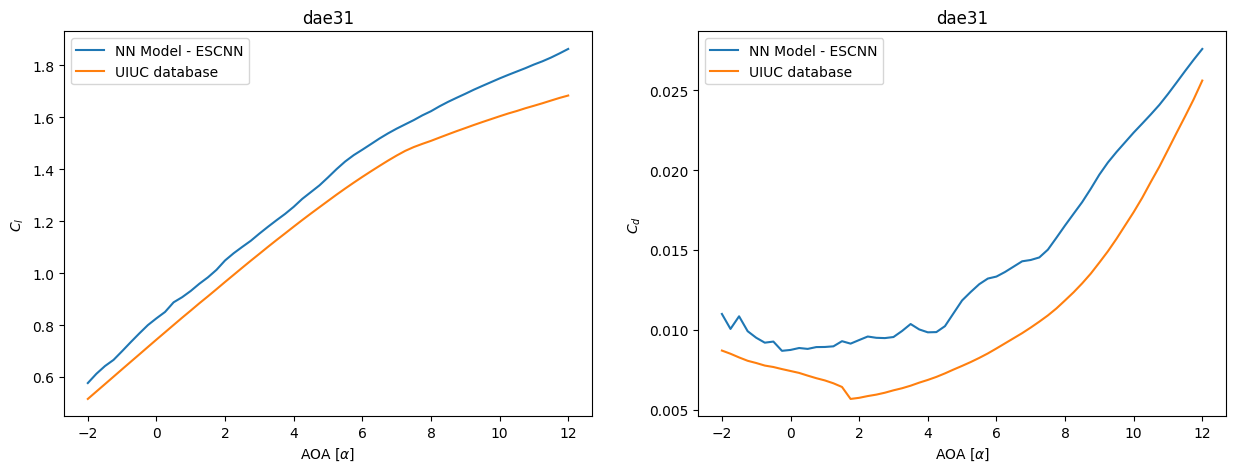

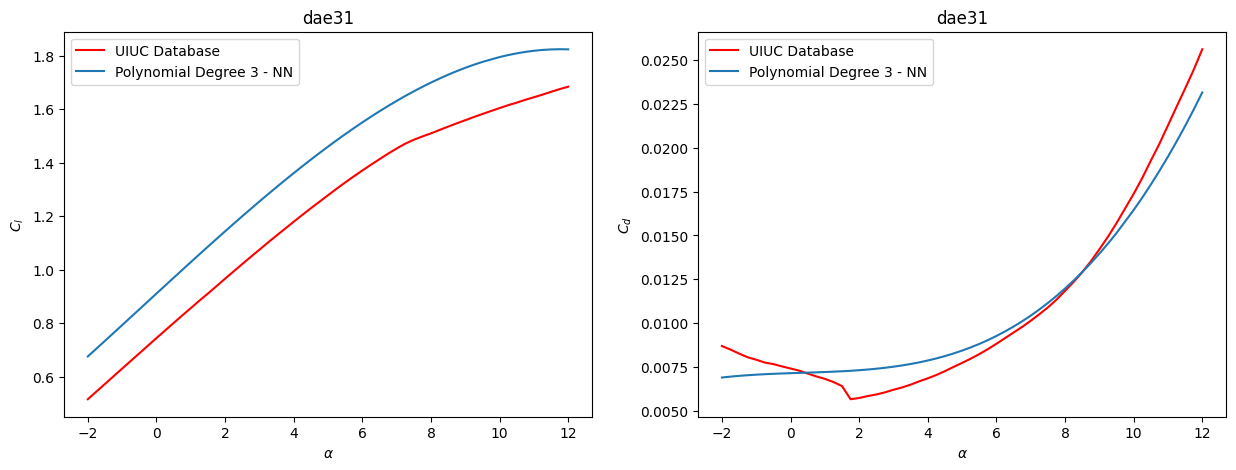

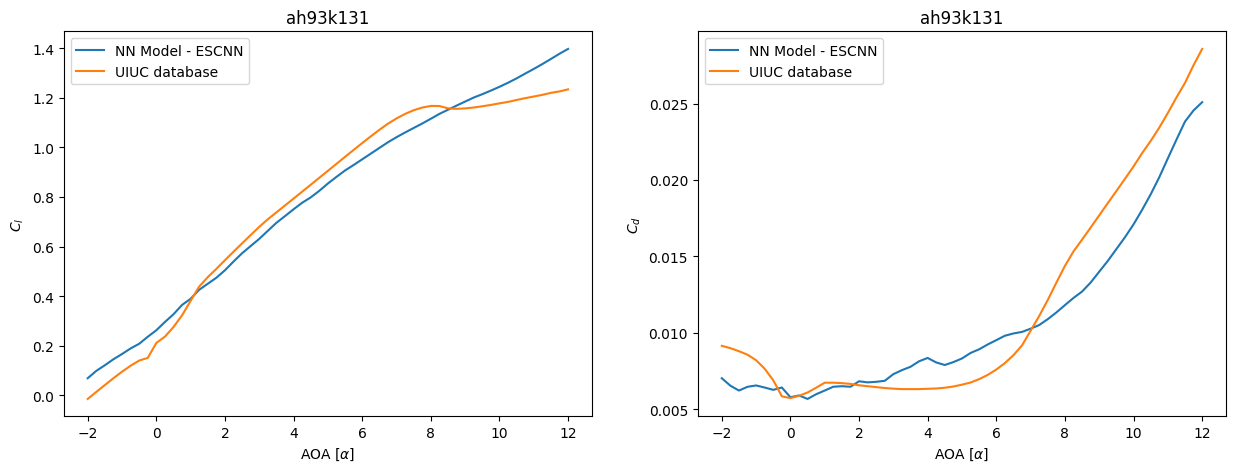

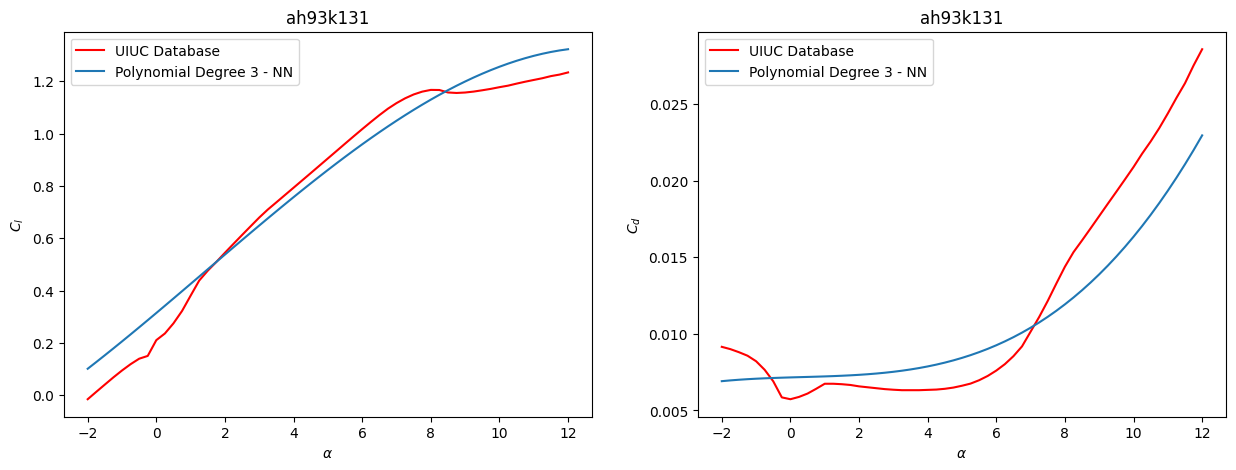

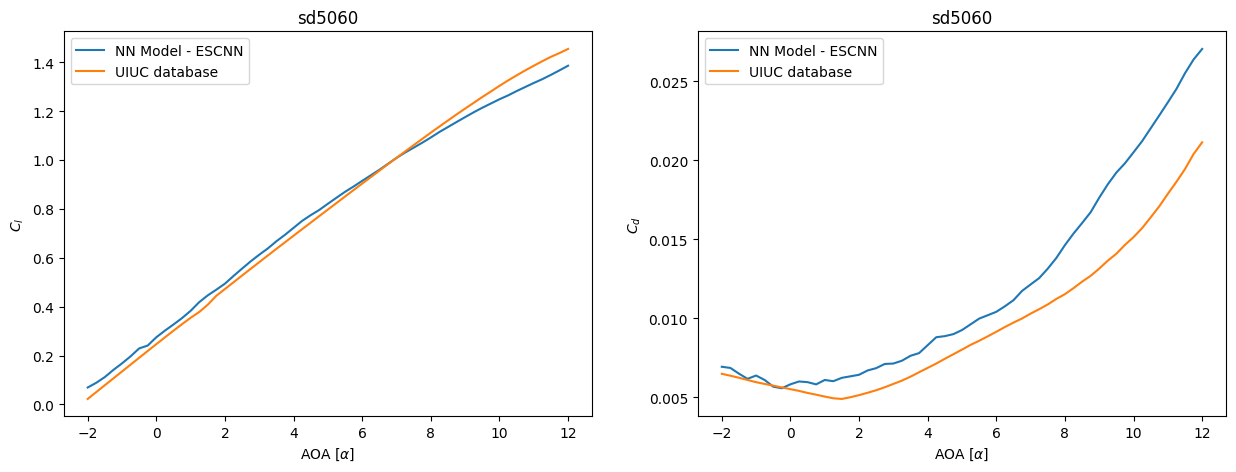

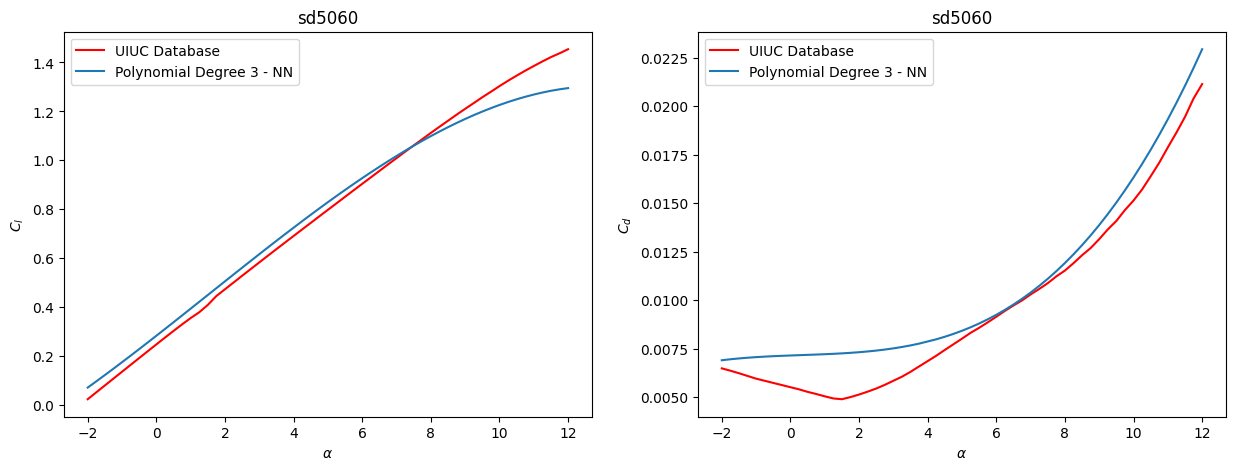

In [10]:
root_airfoil_data = "../wing_section/small_database_testing_csv/"
degree = 3
coord_files = [f for f in os.listdir(root_airfoil_data) if f.endswith('_coordinates.dat')]
coord_bases = {re.sub(r'\_coordinates.dat$', '', f) for f in coord_files}

for keyword in coord_bases:
    # x_t, y_t, Cls_t, Cms_t, Cds_t, alphas_t = prep_data(root_test, keyword)
    x_test, y_test, cl_test, cd_test, aoa_test = prep_data(root_airfoil_data, keyword)
    num_airfoils_test = len(x_test) 

    print(num_airfoils_test)

    if num_airfoils_test != 0:

        # degree = 3

        input_test_cl = []
        input_test_cd = []
        target_cl_test = []
        target_cd_test = []

        for j in range(num_airfoils_test):
            
            input_sequence_cl = []
            input_sequence_cd = []

            output_sequence_cl = []
            output_sequence_cd =[]

            # Prepare the data to input to ESCNN Model
            x_escnn = np.array(x_test[j]).reshape(1, -1)
            y_escnn = np.array(y_test[j]).reshape(1, -1)
            aoa_escnn = np.array(aoa_test[j]).reshape(1, -1)

            elements_ESCNN = organize_data(x_escnn, y_escnn, aoa_escnn)

            if elements_ESCNN.shape != (0,):
                input_escnn = elements_ESCNN

                input_escnn = torch.tensor(input_escnn, dtype=torch.float32).to(device)

                # Evaluate the model on test dataset
                with torch.no_grad():
                    Cl_escnn_pred = af_model_ESCNN_Cl.forward(input_escnn)
                    Cd_escnn_pred = af_model_ESCNN_Cd.forward(input_escnn)
                    
                Cl_escnn_pred = Cl_escnn_pred.cpu().detach().numpy()  # Convert tensor to numpy array
                Cl_escnn_pred = Cl_escnn_pred.squeeze(1)

                Cd_escnn_pred = Cd_escnn_pred.cpu().detach().numpy()  # Convert tensor to numpy array
                Cd_escnn_pred = Cd_escnn_pred.squeeze(1)

                plt_af_polar_comparison = True     # If needed for debugging
                if plt_af_polar_comparison == True:
                    plt.figure(figsize=(15, 5))
                    plt.subplot(1,2,1)
                    plt.plot(aoa_test[j], Cl_escnn_pred)
                    # plt.plot(alphas_t[0], Cl_eval_org_scale)
                    plt.plot(aoa_test[j], cl_test[j])

                    plt.legend(['NN Model - ESCNN', 'UIUC database'])
                    # plt.title(r'$C_d$ vs $\alpha$ for {} airfoil'.format(keyword))
                    plt.title(keyword)
                    plt.xlabel(r'AOA [$\alpha$]')
                    plt.ylabel(r'$C_l$')

                    plt.subplot(1,2,2)
                    plt.plot(aoa_test[j], Cd_escnn_pred)
                    # plt.plot(alphas_t[0], Cl_eval_org_scale)
                    plt.plot(aoa_test[j], cd_test[j])

                    plt.legend(['NN Model - ESCNN', 'UIUC database'])
                    # plt.title(r'$C_d$ vs $\alpha$ for {} airfoil'.format(keyword))
                    plt.title(keyword)
                    plt.xlabel(r'AOA [$\alpha$]')
                    plt.ylabel(r'$C_d$')

            else:
                continue

            aoa_test_i = downsample_to_35(aoa_test[j])
            cl_test_i = downsample_to_35(Cl_escnn_pred)
            cd_test_i = downsample_to_35(Cd_escnn_pred)

            input_sequence_cl = [
                                    x_test[j], y_test [j], aoa_test_i, cl_test_i
                                ]
            
            input_sequence_cd = [
                                    x_test[j], y_test [j], aoa_test_i, cd_test_i
                                ]


            coefficients_cl = np.polyfit(aoa_test[j], cl_test[j], degree)
            coefficients_cd = np.polyfit(aoa_test[j], cd_test[j], degree)

            # Create the polynomial function
            polynomial_cl = np.poly1d(coefficients_cl)
            polynomial_cd = np.poly1d(coefficients_cd)

            output_sequence_cl = coefficients_cl
            output_sequence_cd = coefficients_cd

            # print(output_sequence_cl)

            input_test_cl.append(input_sequence_cl)
            input_test_cd.append(input_sequence_cd)
            target_cl_test.append(output_sequence_cl)
            target_cd_test.append(output_sequence_cd)


        input_test_cl = np.array(input_test_cl, dtype=float).reshape(num_airfoils_test, -1)
        input_test_cd = np.array(input_test_cd, dtype=float).reshape(num_airfoils_test, -1)
        
        target_cl_test = np.array(target_cl_test, dtype=float)
        target_cd_test = np.array(target_cd_test, dtype=float)

        print("Input Cl shape: ", input_test_cl.shape)
        print("Input Cd shape: ", input_test_cd.shape)
        print("Target Cl shape: ", target_cl_test.shape)
        print("Target Cd shape: ", target_cd_test.shape)

        cl_input_data = torch.tensor(input_test_cl, dtype=torch.float32).to(device) 
        cd_input_data = torch.tensor(input_test_cd, dtype=torch.float32).to(device) 

        # y_test_data = torch.tensor(target_cl_test, dtype=torch.float32).to(device)
        cl_target_data= torch.tensor(target_cl_test, dtype=torch.float32).to(device)
        cd_target_data= torch.tensor(target_cd_test, dtype=torch.float32).to(device)

        # Set model to evaluation mode (turns off dropout, batchnorm, etc.)
    
        with torch.no_grad():  # Disable gradient computation for inference
            # predicted_coefficients = model(x_test_data_norm)
            predicted_coefficients_cl = airfoil_cl(cl_input_data)
            predicted_coefficients_cd = airfoil_cd(cd_input_data)

        predicted_coefficients_cl = predicted_coefficients_cl.cpu().detach().numpy()
        predicted_coefficients_cd = predicted_coefficients_cd.cpu().detach().numpy()
        
        cl_target_data = cl_target_data.cpu().detach().numpy()
        cd_target_data = cd_target_data.cpu().detach().numpy()

        # # Optionally: Compare predicted coefficients with true coefficients
        # print("Predicted Coefficients:\n", predicted_coefficients)
        # print("True Coefficients:\n", y_test_data)

        # polynomial_cl_new = np.poly1d(predicted_coefficients[0])
        polynomial_cl_new = np.poly1d(predicted_coefficients_cl[0])
        polynomial_cd_new = np.poly1d(predicted_coefficients_cd[0])

        x_new = np.linspace(aoa_test[0], aoa_test[-1], 100)
        # y_new_cl = polynomial_cl_new(x_new_cl)
        y_new_cl = polynomial_cl_new(x_new)
        y_new_cd = polynomial_cd_new(x_new)

        # plt.figure()
        plt.figure(figsize=(15, 5))
        
        
        plt.subplot(1,2,1)
        plt.plot(aoa_test[0], cl_test[0], color='red', label='UIUC Database')
        plt.plot(x_new[0], y_new_cl[0], label=f'Polynomial Degree {degree} - NN')
        plt.xlabel(r'$\alpha$')
        plt.ylabel(r'$C_l$')
        plt.title(keyword)
        plt.legend()

        plt.subplot(1,2,2)
        plt.plot(aoa_test[0], cd_test[0], color='red', label='UIUC Database')
        plt.plot(x_new[0], y_new_cd[0], label=f'Polynomial Degree {degree} - NN')
        plt.xlabel(r'$\alpha$')
        plt.ylabel(r'$C_d$')
        plt.title(keyword)
        plt.legend()


    else:
        continue

In [10]:
# Initialize the Wing Model (All three - static, dynamic_Vel, dynamic_ang)

# LSTM Model Definition - static wing data 
class LSTMNet_static(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(LSTMNet_static, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.fc2 = nn.Linear(output_size, output_size)

    def forward(self, x):
        lstm_out, (hn, cn) = self.lstm(x)
        out = self.fc(lstm_out)
        out2 = self.fc2(out)
        return out2
    
# LSTM-RBF Model definition - dynamic wing data

class RBFLayer(nn.Module):
    def __init__(self, input_size, num_units):
        super(RBFLayer, self).__init__()
        self.centers = nn.Parameter(torch.randn(num_units, input_size))  # RBF centers
        self.beta = nn.Parameter(torch.ones(num_units))  # Spread parameters for Gaussian kernels

    def forward(self, x):
        # Compute squared Euclidean distance between input and RBF centers
        diff = x.unsqueeze(2) - self.centers.unsqueeze(0).unsqueeze(0)  # (batch_size, seq_len, num_units, input_size)
        dist = torch.sum(diff ** 2, dim=-1)  # (batch_size, seq_len, num_units)
        # Apply Gaussian kernel
        rbf_out = torch.exp(-self.beta * dist)  # (batch_size, seq_len, num_units)
        return rbf_out

class LSTMNet_dynamic(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_rbf_units, output_size):
        super(LSTMNet_dynamic, self).__init__()
        # LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        # Fully connected layer
        self.fc = nn.Linear(hidden_size, output_size)
        # RBF layer
        self.rbf_layer = RBFLayer(output_size, num_rbf_units)
        # Output layer for the final predictions
        self.output_layer = nn.Linear(num_rbf_units, output_size)  # Predicts the 2 outputs per sequence

    def forward(self, x):
        # LSTM layer
        lstm_out, (hn, cn) = self.lstm(x)  # lstm_out shape: [batch_size, sequence_length, hidden_size]
        # Fully connected layer applied to each time step
        fc_out = self.fc(lstm_out)  # shape: [batch_size, sequence_length, fc_output_size]
        # RBF layer applied to each time step
        rbf_out = self.rbf_layer(fc_out)  # shape: [batch_size, sequence_length, num_rbf_units]
        # Output layer to predict 2 outputs for each time step
        out = self.output_layer(rbf_out)  # shape: [batch_size, sequence_length, output_size]
        return out



In [11]:
# Static Model
input_size_wing_stat = 10           # Number of input features
hidden_size_wing_stat = 50          # Hidden LSTM cells
output_size_wing_stat = 2           # Number of output features
num_layers_wing_stat = 3            # Number of LSTM layers

class WingModel_static(LSTMNet_static):
    def __init__(self):
        super(WingModel_static, self).__init__(input_size_wing_stat, hidden_size_wing_stat, output_size_wing_stat, num_layers_wing_stat)

# Initialize the model
wing_model_static = WingModel_static()
wing_model_static.load_state_dict(torch.load('/mnt/e/Course_Materials/ROM/wing_model/trained_models/2024-11-19_LSTM_eMO_wingModel_static_lr0.002_e1200_nL3_numNN50.pth'))
wing_model_static = wing_model_static.to(device)
wing_model_static.eval()

# Load the scaler
input_scaler_wing_stat = joblib.load('/mnt/e/Course_Materials/ROM/wing_model/saved_scalers/2024-11-19_LSTM_eMO_wingModel_static_ipScaler_lr0.002_e1200_nL3_numNN50.pkl')
output_scaler_wing_stat = joblib.load('/mnt/e/Course_Materials/ROM/wing_model/saved_scalers/2024-11-19_LSTM_eMO_wingModel_static_opScaler_lr0.002_e1200_nL3_numNN50.pkl')

#------------------------------------------------------------------
# Dynamic Model - Angle
input_size_wing_dyn_ang = 9           # Number of input features
hidden_size_wing_dyn_ang = 50          # Hidden LSTM cells
output_size_wing_dyn_ang = 4           # Number of output features
num_layers_wing_dyn_ang = 4            # Number of LSTM layers
num_RBF_units_wing_dyn_ang = 128       # Number of RBF units

class WingModel_dynamic_angle(LSTMNet_dynamic):
    def __init__(self):
        super(WingModel_dynamic_angle, self).__init__(input_size_wing_dyn_ang, hidden_size_wing_dyn_ang, num_layers_wing_dyn_ang, num_RBF_units_wing_dyn_ang, output_size_wing_dyn_ang)

# Initialize the model
wing_model_dyn_ang = WingModel_dynamic_angle()
wing_model_dyn_ang.load_state_dict(torch.load('/mnt/e/Course_Materials/ROM/wing_model/trained_models/2024-11-04_LSTM_eMO_wingModel_dynmic_ang_lr0.0007_e2000_nL4_numNN50.pth'))
wing_model_dyn_ang = wing_model_dyn_ang.to(device)
wing_model_dyn_ang.eval()

input_scaler_wing_dyn_ang = joblib.load('/mnt/e/Course_Materials/ROM/wing_model/saved_scalers/2024-11-04_LSTM_eMO_wingModel_dynmic_ang_ipScaler_lr0.0007_e2000_nL4_numNN50.pkl')
output_scaler_wing_dyn_ang = joblib.load('/mnt/e/Course_Materials/ROM/wing_model/saved_scalers/2024-11-04_LSTM_eMO_wingModel_dynmic_ang_opScaler_lr0.0007_e2000_nL4_numNN50.pkl')
#------------------------------------------------------------------

# Dynamic Model - Velocity_Z

input_size_wing_dyn_vel = 9           # Number of input features
hidden_size_wing_dyn_vel = 50          # Hidden LSTM cells
output_size_wing_dyn_vel = 4           # Number of output features
num_layers_wing_dyn_vel = 4            # Number of LSTM layers
num_RBF_units_wing_dyn_vel = 128       # Number of RBF units

class WingModel_dynamic_velocity(LSTMNet_dynamic):
    def __init__(self):
        super(WingModel_dynamic_velocity, self).__init__(input_size_wing_dyn_vel, hidden_size_wing_dyn_vel, num_layers_wing_dyn_vel, 
                                                      num_RBF_units_wing_dyn_vel, output_size_wing_dyn_vel)
        
# Initialize the model
wing_model_dyn_vel = WingModel_dynamic_velocity()
wing_model_dyn_vel.load_state_dict(torch.load('/mnt/e/Course_Materials/ROM/wing_model/trained_models/2024-11-04_LSTM_eMO_wingModel_dynmic_vel_lr0.0005_e2000_nL4_numNN50.pth'))
wing_model_dyn_vel = wing_model_dyn_vel.to(device)
wing_model_dyn_vel.eval()

input_scaler_wing_dyn_vel = joblib.load('/mnt/e/Course_Materials/ROM/wing_model/saved_scalers/2024-11-04_LSTM_eMO_wingModel_dynmic_vel_ipScaler_lr0.0005_e2000_nL4_numNN50.pkl')
output_scaler_wing_dyn_vel = joblib.load('/mnt/e/Course_Materials/ROM/wing_model/saved_scalers/2024-11-04_LSTM_eMO_wingModel_dynmic_vel_opScaler_lr0.0005_e2000_nL4_numNN50.pkl')
    

/tmp/ipykernel_152096/2496514573.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  wing_model_static.load_state_dict(torch.load('/mnt/e/Course_Materials/ROM/wing_model/tr

In [20]:
# Prepare wing dataset

# Condition function to filter subdirectories
def subdir_condition(subdir_name):
    """
    Condition: Only process subdirectories whose names start with 'propeller-example_dji'.
    Modify this function to apply a specific filtering logic.
    """
    return subdir_name.startswith('wing_dataset')  # Change this condition as needed


class WingDataset(Dataset):
    def __init__(self, root_dir, af_data_path='/mnt/e/Course_Materials/ROM/wing_model/wing_section/small_database_testing_csv', subdir_condition=None):
        """
        Args:
            root_dir (string): Root directory with subdirectories containing CSV files.
            af_data_path (string): Airfoil polar database directory contaiing airfoil polars of used airfoils.            
            subdir_condition (callable, optional): A function or condition to filter subdirectories by name.
        """
        self.root_dir = root_dir
        self.data = []
        self.targets = []
        self.time_data = []  # Store time data separately
        self.AOA_data = []
        self.v_inf_data = []
        self.cl_data = []
        self.cd_data = []

        self.cl_data = []
        self.cd_data = []
        self.fft_cl_r = []
        self.fft_cl_i = []
        self.fft_cd_r = []
        self.fft_cd_i = []

        self.model_type = []
        
        self.subdir_condition = subdir_condition
        self.af_data_path = af_data_path

        # Traverse the root directory to gather data
        self._load_data()

    def _load_data(self):
        """
        Helper function to read CSV files from each subdirectory and extract relevant columns.
        """
        # Iterate through each subdirectory in the root directory
        for subdir, _, files in os.walk(self.root_dir):
            subdir_name = os.path.basename(subdir)
            
            # Apply subdirectory name condition
            if self.subdir_condition and not self.subdir_condition(subdir_name):
                continue

            for file in files:

                if file.endswith("_convergence.csv"):
                    # Load the CSV file
                    csv_path = os.path.join(subdir, file)
                    df = pd.read_csv(csv_path)
                    
                    # Extract necessary columns for input features from wing_convergence.csv
                    time = df['T'].values  # Time
                    
                    v_inf = df['Vinf'].values
                    AOA = df['alpha(eff)'].values
                    theta = df['theta'].values
                    vz = df['vVehicle_z'].values
                                        
                    # Extract Cl and Cq for output variables
                    cl = df['CL'].values  # Lift coefficient (CL)
                    cd = df['CD'].values  # Drag coefficient (CD)

                    # -----------------------------------------------------------------------------------------
                    # Determine the type of model - Model switching
                    # -----------------------------------------------------------------------------------------
                    unique_AOA = np.unique(AOA)
                    unique_vz = np.unique(vz)

                    if len(unique_AOA) > 1:
                        wing_model_type = 'dynamic_AOA'
                        self.model_type.append(wing_model_type)
                    elif len(unique_vz) > 1:
                        wing_model_type = 'dynamic_vz'
                        self.model_type.append(wing_model_type)
                    else:
                        wing_model_type = 'static'
                        self.model_type.append(wing_model_type)


                    # -----------------------------------------------------------------------------------------
                    # Data processing
                    # -----------------------------------------------------------------------------------------
                    fft_cl = fft(cl)                                # Fast Fourier Transforms - Needed if the data 
                    fft_cl_real = np.real(fft_cl)                   # has sinusoidal patterns - Will be later added in the 
                    fft_cl_imag = np.imag(fft_cl)                   # output_sequence

                    fft_cd = fft(cd)
                    fft_cd_real = np.real(fft_cd)
                    fft_cd_imag = np.imag(fft_cd)

                    # Add the geometry parameters
                    geom_data_path = os.path.join(subdir, 'wing_geometry_data.csv')         # Read from wing_geometry_data.csv file - b, ar, tr, sweep, dihedral
                    geom_df = pd.read_csv(geom_data_path, nrows=1)

                    ones_empty = np.ones_like(time)                                         # Empty array of ones
                    
                    b_data = geom_df["b_wing"].values
                    b_data_array = geom_df["b_wing"].values * ones_empty                    # Making this an array simplifies things later
                    
                    ar_data = geom_df["ar_wing"].values
                    ar_data_array = geom_df["ar_wing"].values * ones_empty
                    
                    tr_data = geom_df["tr"].values
                    tr_data_array = geom_df["tr"].values * ones_empty

                    sweep_data = geom_df["lambda"].values
                    sweep_data_array = geom_df["lambda"].values * ones_empty
                    
                    gamma_data = geom_df["gamma"].values
                    gamma_data_array = geom_df["gamma"].values * ones_empty
                

                    # Extract the airfoil details
                    af_name = geom_df["airfoil "].values
                    extension = '.csv'
                    af_name = str(af_name[0]+extension)

                    af_name_new = af_name.split('-')
                    af_coordinate = str(af_name_new[1]+'_coordinates.dat')          # Name of airfoil coordinates. Adjust it according to the names being used
                    print(af_coordinate)
                    
                    af_polar_data = pd.read_csv(os.path.join(self.af_data_path, af_name), skiprows=10)
                    # af_polar_data = af_polar_data[[(af_polar_data["Alpha"] >= -2) & (af_polar_data["Alpha"] <= 12)]]
                    # af_coordinate_data = pd.read_csv(os.path.join(self.af_data_path, af_coordinate), delim_whitespace=True)  # or use delimiter=','
                    af_coordinate_data = np.loadtxt(os.path.join(self.af_data_path, af_coordinate))

                    af_coordinate_x = af_coordinate_data[:,0]
                    af_coordinate_y = af_coordinate_data[:,1] 

                    AOA_af_polar = af_polar_data["Alpha"].values
                    cl_af_polar = af_polar_data["Cl"].values
                    cd_af_polar = af_polar_data["Cd"].values

                    # Fit a polynomial to Cl and Cd data
                    # Create cubic spline interpolation
                    spline_cl_airfoil = CubicSpline(AOA_af_polar, cl_af_polar)
                    spline_cd_airfoil = CubicSpline(AOA_af_polar, cd_af_polar)

                    cl_poly_coeff = np.polyfit(AOA_af_polar, cl_af_polar, deg=6)
                    cd_poly_coeff = np.polyfit(AOA_af_polar, cd_af_polar, deg=6)

                    cl_airfoil_calc = spline_cl_airfoil(AOA)
                    cd_airfoil_calc = spline_cd_airfoil(AOA)

                    # ------------------------------------------------------------------------------------------------------------------
                    # Note - To determine the airfoil aerodynamic coefficients, there are two approaaches.
                    # 1. Use the polar file from the database to fit a polynomial function and then estimate the Cl/Cd for any given AOA.
                    # 2. USe the pre-trained Neural Network to predict the Cl/Cd.  
                    # ------------------------------------------------------------------------------------------------------------------
                    
                    # Using approach 2 - Using RBF NN to predict the Cl and Cd
                    # ------------------------------------------------------------------------------------------------------------------
                
                    degree_af_polyfit_coeff = 3
                    
                    input_sequence_cl_NN = []
                    input_sequence_cd_NN = []

                    # Prepare the data to input to ESCNN Model
                    x_escnn = np.array(downsample_to_35(af_coordinate_x)).reshape(1, -1)
                    y_escnn = np.array(downsample_to_35(af_coordinate_y)).reshape(1, -1)
                    aoa_escnn = np.array(AOA_af_polar).reshape(1, -1)

                    elements_ESCNN = organize_data(x_escnn, y_escnn, aoa_escnn)

                    if elements_ESCNN.shape != (0,):
                        input_escnn = elements_ESCNN

                        input_escnn = torch.tensor(input_escnn, dtype=torch.float32).to(device)

                        # Evaluate the model on test dataset
                        with torch.no_grad():
                            Cl_escnn_pred = af_model_ESCNN_Cl.forward(input_escnn)
                            Cd_escnn_pred = af_model_ESCNN_Cd.forward(input_escnn)
                            
                        Cl_escnn_pred = Cl_escnn_pred.cpu().detach().numpy()  # Convert tensor to numpy array
                        Cl_escnn_pred = Cl_escnn_pred.squeeze(1)

                        Cd_escnn_pred = Cd_escnn_pred.cpu().detach().numpy()  # Convert tensor to numpy array
                        Cd_escnn_pred = Cd_escnn_pred.squeeze(1)

                        plt_af_polar_comparison = False     # If needed for debugging
                        if plt_af_polar_comparison == True:
                            plt.figure()
                            plt.plot(aoa_test[j], Cl_escnn_pred)
                            # plt.plot(alphas_t[0], Cl_eval_org_scale)
                            plt.plot(aoa_test[j], cl_test[j])

                            plt.legend(['NN Model - ESCNN', 'UIUC database'])
                            # plt.title(r'$C_d$ vs $\alpha$ for {} airfoil'.format(keyword))
                            plt.xlabel(r'AOA [$\alpha$]')
                            plt.ylabel(r'$C_l$')

                    else:
                        continue

                    af_coordinate_x_i = downsample_to_35(af_coordinate_x)
                    af_coordinate_y_i = downsample_to_35(af_coordinate_y)
                    AOA_af_polar_i = downsample_to_35(AOA_af_polar)
                    cl_af_RBF_i = downsample_to_35(Cl_escnn_pred)
                    cd_af_RBF_i = downsample_to_35(Cd_escnn_pred)

                    input_sequence_cl_NN = [
                                            af_coordinate_x_i, af_coordinate_y_i, AOA_af_polar_i, cl_af_RBF_i
                                        ]
                    
                    input_sequence_cd_NN = [
                                            af_coordinate_x_i, af_coordinate_y_i, AOA_af_polar_i, cd_af_RBF_i
                                        ]



                    input_sequence_cl_NN = np.array(input_sequence_cl_NN, dtype=float).reshape(1, -1)
                    input_sequence_cd_NN = np.array(input_sequence_cd_NN, dtype=float).reshape(1, -1)
                    
                    print("Airfoil Cl NN - Input shape: ", input_sequence_cl_NN.shape)
                    print("Airfoil Cd NN - Input shape: ", input_sequence_cd_NN.shape)

                    NN_cl_model_ip_data = torch.tensor(input_sequence_cl_NN, dtype=torch.float32).to(device) 
                    NN_cd_model_ip_data = torch.tensor(input_sequence_cd_NN, dtype=torch.float32).to(device) 

            
                    # Neural network model to predict the airfoil aerodynamic coeficients    
                    with torch.no_grad():  # Disable gradient computation for inference
                        predicted_coefficients_cl = airfoil_cl(NN_cl_model_ip_data)
                        predicted_coefficients_cd = airfoil_cd(NN_cd_model_ip_data)

                    predicted_af_coefficients_cl = predicted_coefficients_cl.cpu().detach().numpy()
                    predicted_af_coefficients_cd = predicted_coefficients_cd.cpu().detach().numpy()
                    

                    # polynomial_cl_new = np.poly1d(predicted_coefficients[0])
                    polynomial_cl_pred = np.poly1d(predicted_af_coefficients_cl[0])
                    polynomial_cd_pred = np.poly1d(predicted_af_coefficients_cd[0])

                    x_new = np.linspace(AOA_af_polar[0], AOA_af_polar[-1], 100)
                    y_new_cl = polynomial_cl_pred(x_new)
                    y_new_cd = polynomial_cd_pred(x_new)

                    plt_af_polar_NN = False         # Airfoil polar comparison plot [True/False]
                    if plt_af_polar_NN == True:
                        plt.figure(figsize=(15, 5))
                        # plt.title(af_name)
                        
                        plt.subplot(1,2,1)
                        plt.plot(AOA_af_polar, cl_af_polar, color='red', label='UIUC Database')
                        plt.plot(x_new, y_new_cl, label=f'Polynomial Degree {degree} - NN')
                        plt.xlabel(r'$\alpha$')
                        plt.ylabel(r'$C_l$')
                        plt.title(af_name)
                        plt.legend()


                        plt.subplot(1,2,2)
                        plt.plot(AOA_af_polar, cd_af_polar, color='red', label='UIUC Database')
                        plt.plot(x_new, y_new_cd, label=f'Polynomial Degree {degree} - NN')
                        plt.xlabel(r'$\alpha$')
                        plt.ylabel(r'$C_d$')
                        plt.title(af_name)
                        plt.legend()
                    
                    cl_af_NN = polynomial_cl_pred(AOA)
                    cd_af_NN = polynomial_cd_pred(AOA)

                    plt_af_lvl_coeff = False            # Airfoil level Cl and Cd - Predicted from the NN
                    if plt_af_lvl_coeff==True:
                        plt.figure(figsize=(15, 5))
                        
                        
                        plt.subplot(1,2,1)
                        plt.plot(time, cl_airfoil_calc, color='red', label='UIUC Database')
                        plt.plot(time, cl_af_NN, label=f'Polynomial Degree {degree} - NN')
                        plt.xlabel(r'$\alpha$')
                        plt.ylabel(r'$C_l$')
                        plt.title(af_name)
                        plt.legend()

                        plt.subplot(1,2,2)
                        plt.plot(time, cd_airfoil_calc, color='red', label='UIUC Database')
                        plt.plot(time, cd_af_NN, label=f'Polynomial Degree {degree} - NN')
                        plt.xlabel(r'$\alpha$')
                        plt.ylabel(r'$C_d$')
                        plt.title(af_name)
                        plt.legend()
                    
                    #-------------------------------------------------------------------------------------------------------------------
                    # -----------------------------------------------------------------------------------------
                    # Calculate Wing Aerodynamic Coefficients
                    # -----------------------------------------------------------------------------------------
                    # Calculate the Cl and Cd using the emperical equations using airfoil aerodynamic coefficients
                    

                    vel_comp_factor_cl = 0.01                # Assumed from trial & error. Depends on flow velocity and wing geometry
                    vel_comp_factor_cd = 0.00005              # Assumed from trial & error. Depends on flow velocity and wing geometry
                    e = 0.85                                # Oswald factor

                    # cl_wing_calc = cl_airfoil_calc / (1 + cl_airfoil_calc / (np.pi * ar_data * e)) * vel_comp_factor_cl

                    # cd_induced = (cl_wing_calc ** 2) / (np.pi * ar_data * e) * vel_comp_factor_cd

                    cl_wing_calc = cl_af_NN / (1 + cl_af_NN / (np.pi * ar_data * e)) * vel_comp_factor_cl

                    cd_induced = (cl_wing_calc ** 2) / (np.pi * ar_data * e) * vel_comp_factor_cd

                    # Total drag coefficient for the wing
                    cd_wing_calc = cd_af_NN + cd_induced
                    # cd_wing_calc = cd_airfoil_calc + cd_induced

                    # For each simulation, the input sequence is structured as (n_timesteps, n_features)
                    sequence_inputs = []
                    sequence_outputs = []

                    if wing_model_type == 'static':
                        print("hello!")
                        for i in range(len(time)):
                            # Each time step has time, omega, and predefined variables: alpha, J, theta, yaw, tilt
                            input_data = [
                                time[i], AOA[i], v_inf[i], b_data_array[i], ar_data_array[i], tr_data_array[i], sweep_data_array[i], 
                                gamma_data_array[i], cl_wing_calc[i], cd_wing_calc[i]
                            ]
                            # output_data = [cl[i], cd[i]]
                            sequence_inputs.append(input_data)
                            # sequence_outputs.append(output_data)
                    
                    elif wing_model_type == 'dynamic_AOA':
                        for i in range(len(time)):
                            input_data = [
                            time[i], AOA[i], v_inf[i], vz[i], b_data_array[i], ar_data_array[i], tr_data_array[i], sweep_data_array[i], 
                            gamma_data_array[i]#, cl_wing_calc[i], cd_wing_calc[i]
                            ]
                            # output_data = [fft_cl_real[i], fft_cl_imag[i], fft_cd_real[i], fft_cd_imag[i]]
                            sequence_inputs.append(input_data)
                            # sequence_outputs.append(output_data)
                    
                    elif wing_model_type == 'dynamic_vz':
                        for i in range(len(time)):
                            input_data = [
                                time[i], AOA[i], v_inf[i], vz[i], b_data_array[i], ar_data_array[i], tr_data_array[i], sweep_data_array[i], 
                                gamma_data_array[i]#, cl_wing_calc[i], cd_wing_calc[i]
                                ]
                            # output_data = [fft_cl_real[i], fft_cl_imag[i], fft_cd_real[i], fft_cd_imag[i]]
                            sequence_inputs.append(input_data)
                            # sequence_outputs.append(output_data)


                    sequence_inputs = np.array([sequence_inputs], dtype=float)
                    # sequence_outputs = np.array([sequence_outputs], dtype=float)

                    # Append input sequence (n_timesteps, num_features) and output (CT, CQ)
                    self.data.append(sequence_inputs)
                    # self.targets.append(sequence_outputs)  # Append the whole CT and CQ sequences
                    
                    # -----------------------------------------------------------------------------------------
                    # Store the following in separate lists for easy access
                    # -----------------------------------------------------------------------------------------
                    self.time_data.append(time)
                    self.AOA_data.append(AOA)
                    self.v_inf_data.append(v_inf)
                    
                    self.cl_data.append(cl)
                    self.cd_data.append(cd)

                    self.fft_cl_r.append(fft_cl_real)
                    self.fft_cl_i.append(fft_cl_imag)
                    self.fft_cd_r.append(fft_cd_real)
                    self.fft_cd_i.append(fft_cd_imag)


    def __len__(self):
        """
        Returns the total number of sequences in the dataset.
        """
        return len(self.data)

    def __getitem__(self, idx):
        """
        Returns a single sequence and its targets.
        """
        inputs = self.data[idx]  # Input sequence: (n_timesteps, n_features)
        targets = self.targets[idx]  # Output: (n_timesteps, 2)
        # return inputs, targets
        return torch.tensor(inputs, dtype=torch.float32), torch.tensor(targets, dtype=torch.float32)

    def get_variable(self, variable_name):
        """
        Returns a list of arrays for the specified variable.
        Args:
            'time' - timesteps
            
        """
        if variable_name == 'time':
            return self.time_data  # Return all time steps for each simulation
        elif variable_name == 'CL':
            return self.cl_data  # Return all omega (RPM) values for each simulation
        elif variable_name == 'CD':
            return self.cd_data
        elif variable_name == 'AOA':
            return self.AOA_data
        elif variable_name == 'Vinf':
            return self.v_inf_data  
        elif variable_name == 'fft_cl':
            return self.fft_cl_r, self.fft_cl_i 
        elif variable_name == 'fft_cd':
            return self.fft_cd_r, self.fft_cd_i 
        elif variable_name == 'model_type':
            return self.model_type
        else:
            raise ValueError(f"Variable {variable_name} not supported.")

naca6412_coordinates.dat
Airfoil Cl NN - Input shape:  (1, 140)
Airfoil Cd NN - Input shape:  (1, 140)
The selected model is - dynamic_AOA
Input shape: torch.Size([1, 198, 9])
naca6412_coordinates.dat
Airfoil Cl NN - Input shape:  (1, 140)
Airfoil Cd NN - Input shape:  (1, 140)
hello!
The selected model is - static
Input shape: torch.Size([1, 198, 10])
Whats up
naca6412_coordinates.dat
Airfoil Cl NN - Input shape:  (1, 140)
Airfoil Cd NN - Input shape:  (1, 140)
hello!
The selected model is - static
Input shape: torch.Size([1, 198, 10])
Whats up


/mnt/e/Course_Materials/ROM/wing_model/wing_env_311/lib/python3.11/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/mnt/e/Course_Materials/ROM/wing_model/wing_env_311/lib/python3.11/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


naca6412_coordinates.dat
Airfoil Cl NN - Input shape:  (1, 140)
Airfoil Cd NN - Input shape:  (1, 140)
hello!
The selected model is - static
Input shape: torch.Size([1, 198, 10])
Whats up
naca6412_coordinates.dat
Airfoil Cl NN - Input shape:  (1, 140)
Airfoil Cd NN - Input shape:  (1, 140)
hello!
The selected model is - static
Input shape: torch.Size([1, 198, 10])
Whats up
naca6412_coordinates.dat
Airfoil Cl NN - Input shape:  (1, 140)
Airfoil Cd NN - Input shape:  (1, 140)
hello!
The selected model is - static
Input shape: torch.Size([1, 198, 10])
Whats up
naca6412_coordinates.dat
Airfoil Cl NN - Input shape:  (1, 140)
Airfoil Cd NN - Input shape:  (1, 140)
The selected model is - dynamic_vz
Input shape: torch.Size([1, 198, 9])
naca6412_coordinates.dat
Airfoil Cl NN - Input shape:  (1, 140)
Airfoil Cd NN - Input shape:  (1, 140)
The selected model is - dynamic_vz
Input shape: torch.Size([1, 198, 9])
naca6412_coordinates.dat
Airfoil Cl NN - Input shape:  (1, 140)
Airfoil Cd NN - Input 

/mnt/e/Course_Materials/ROM/wing_model/wing_env_311/lib/python3.11/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/mnt/e/Course_Materials/ROM/wing_model/wing_env_311/lib/python3.11/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/mnt/e/Course_Materials/ROM/wing_model/wing_env_311/lib/python3.11/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/mnt/e/Course_Materials/ROM/wing_model/wing_env_311/lib/python3.11/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/mnt/e/Course_Materials/ROM/wing_model/wing_env_311/lib/python3.11/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real di

naca6412_coordinates.dat
Airfoil Cl NN - Input shape:  (1, 140)
Airfoil Cd NN - Input shape:  (1, 140)
The selected model is - dynamic_vz
Input shape: torch.Size([1, 198, 9])
naca6412_coordinates.dat
Airfoil Cl NN - Input shape:  (1, 140)
Airfoil Cd NN - Input shape:  (1, 140)
The selected model is - dynamic_vz
Input shape: torch.Size([1, 198, 9])
naca4412_coordinates.dat
Airfoil Cl NN - Input shape:  (1, 140)
Airfoil Cd NN - Input shape:  (1, 140)
The selected model is - dynamic_AOA
Input shape: torch.Size([1, 198, 9])


/mnt/e/Course_Materials/ROM/wing_model/wing_env_311/lib/python3.11/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/mnt/e/Course_Materials/ROM/wing_model/wing_env_311/lib/python3.11/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/mnt/e/Course_Materials/ROM/wing_model/wing_env_311/lib/python3.11/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/mnt/e/Course_Materials/ROM/wing_model/wing_env_311/lib/python3.11/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/mnt/e/Course_Materials/ROM/wing_model/wing_env_311/lib/python3.11/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real di

naca4412_coordinates.dat
Airfoil Cl NN - Input shape:  (1, 140)
Airfoil Cd NN - Input shape:  (1, 140)
The selected model is - dynamic_vz
Input shape: torch.Size([1, 198, 9])
naca4412_coordinates.dat
Airfoil Cl NN - Input shape:  (1, 140)
Airfoil Cd NN - Input shape:  (1, 140)
The selected model is - dynamic_vz
Input shape: torch.Size([1, 198, 9])
naca4412_coordinates.dat
Airfoil Cl NN - Input shape:  (1, 140)
Airfoil Cd NN - Input shape:  (1, 140)
The selected model is - dynamic_vz
Input shape: torch.Size([1, 198, 9])


/mnt/e/Course_Materials/ROM/wing_model/wing_env_311/lib/python3.11/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/mnt/e/Course_Materials/ROM/wing_model/wing_env_311/lib/python3.11/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/mnt/e/Course_Materials/ROM/wing_model/wing_env_311/lib/python3.11/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/mnt/e/Course_Materials/ROM/wing_model/wing_env_311/lib/python3.11/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/mnt/e/Course_Materials/ROM/wing_model/wing_env_311/lib/python3.11/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real di

naca4412_coordinates.dat
Airfoil Cl NN - Input shape:  (1, 140)
Airfoil Cd NN - Input shape:  (1, 140)
The selected model is - dynamic_AOA
Input shape: torch.Size([1, 198, 9])
naca4412_coordinates.dat
Airfoil Cl NN - Input shape:  (1, 140)
Airfoil Cd NN - Input shape:  (1, 140)
hello!
The selected model is - static
Input shape: torch.Size([1, 198, 10])
Whats up
naca4412_coordinates.dat
Airfoil Cl NN - Input shape:  (1, 140)
Airfoil Cd NN - Input shape:  (1, 140)
hello!
The selected model is - static
Input shape: torch.Size([1, 198, 10])
Whats up


/mnt/e/Course_Materials/ROM/wing_model/wing_env_311/lib/python3.11/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/mnt/e/Course_Materials/ROM/wing_model/wing_env_311/lib/python3.11/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


naca4412_coordinates.dat
Airfoil Cl NN - Input shape:  (1, 140)
Airfoil Cd NN - Input shape:  (1, 140)
hello!
The selected model is - static
Input shape: torch.Size([1, 198, 10])
Whats up
naca4412_coordinates.dat
Airfoil Cl NN - Input shape:  (1, 140)
Airfoil Cd NN - Input shape:  (1, 140)
hello!
The selected model is - static
Input shape: torch.Size([1, 198, 10])
Whats up
naca4412_coordinates.dat
Airfoil Cl NN - Input shape:  (1, 140)
Airfoil Cd NN - Input shape:  (1, 140)
hello!
The selected model is - static
Input shape: torch.Size([1, 198, 10])
Whats up


/tmp/ipykernel_152096/327241834.py:119: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(15, 5))


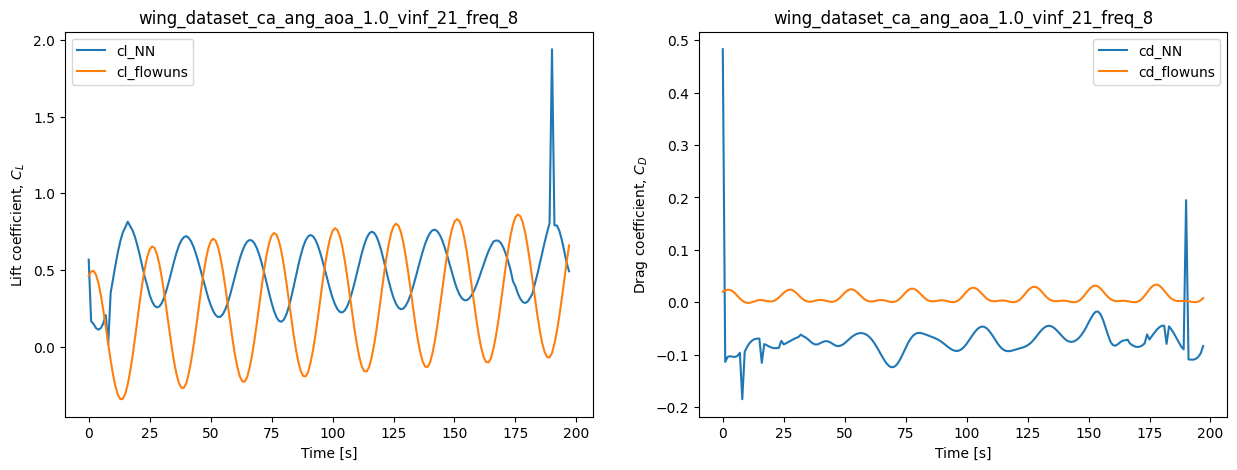

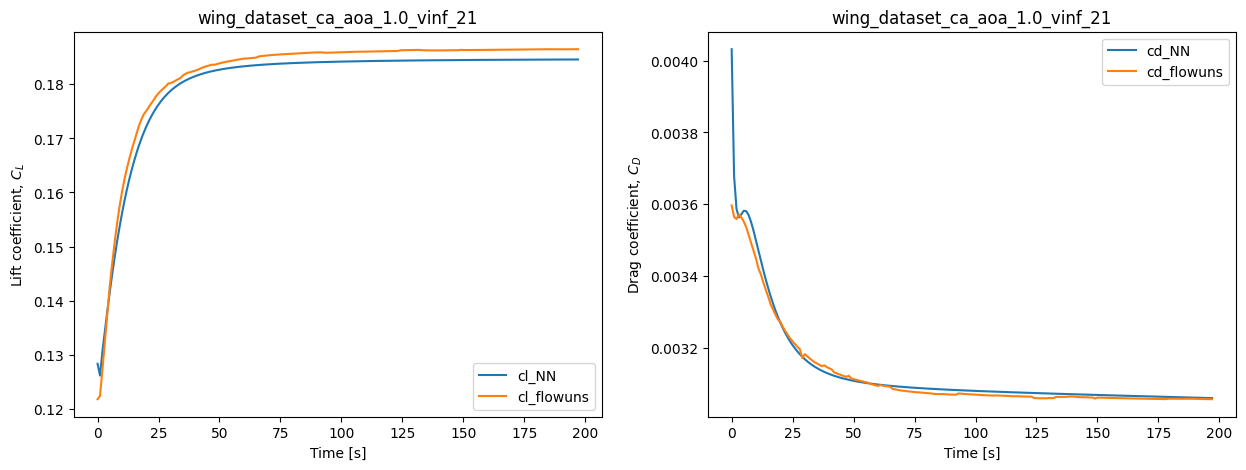

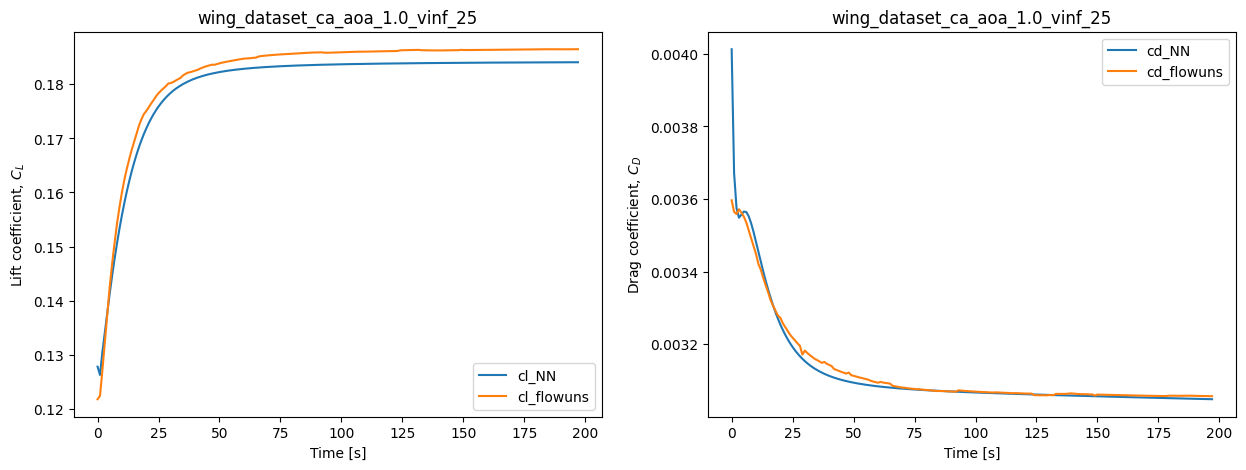

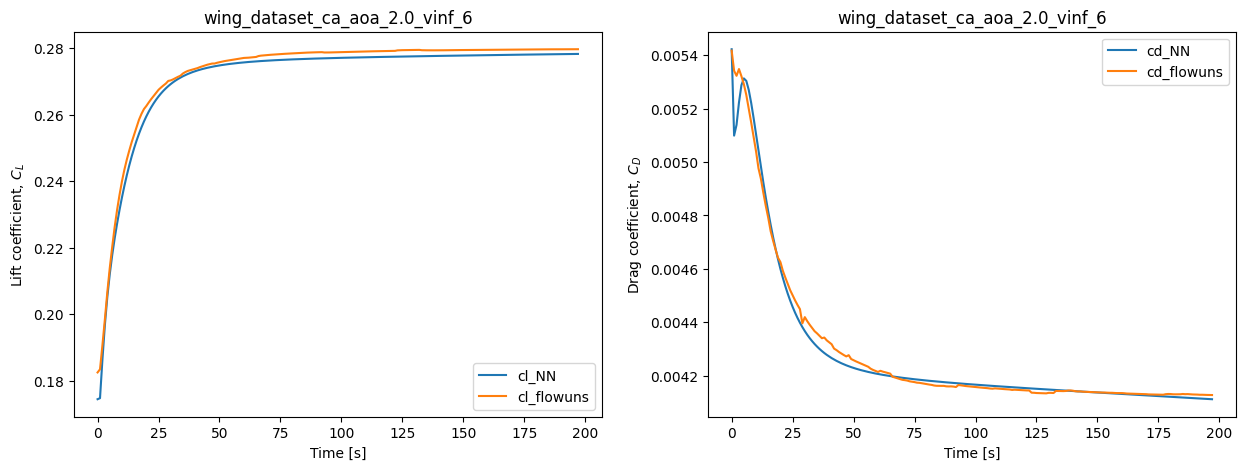

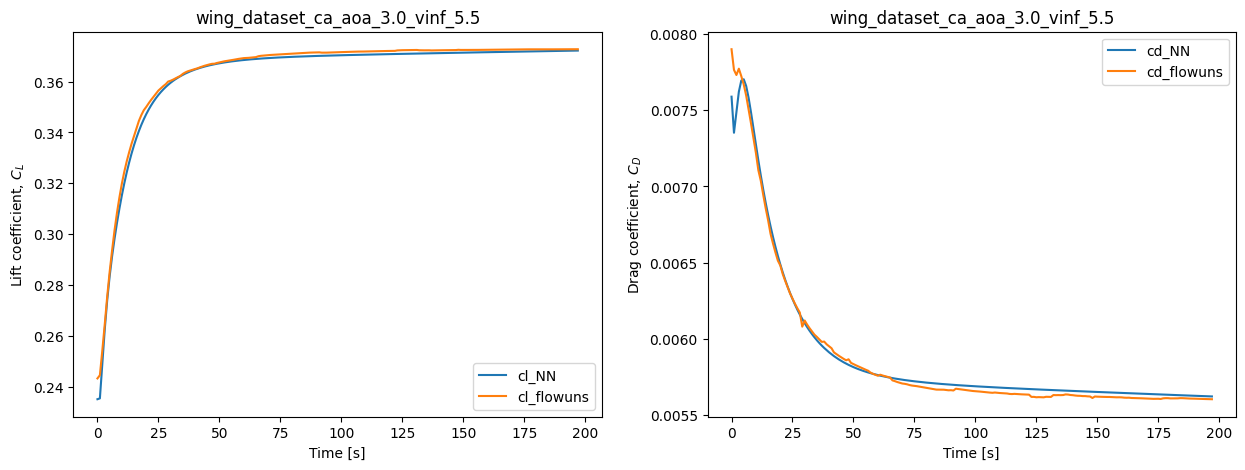

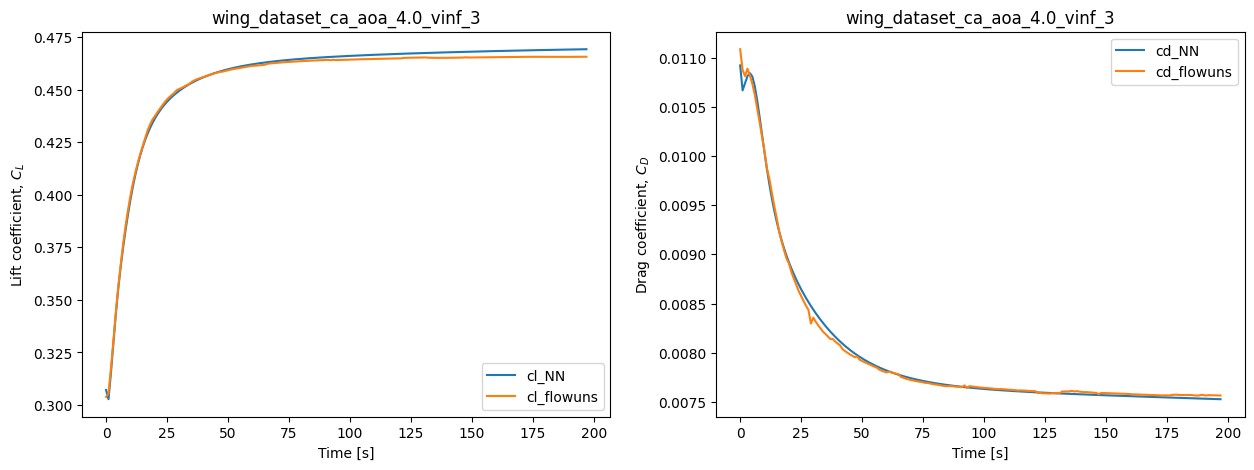

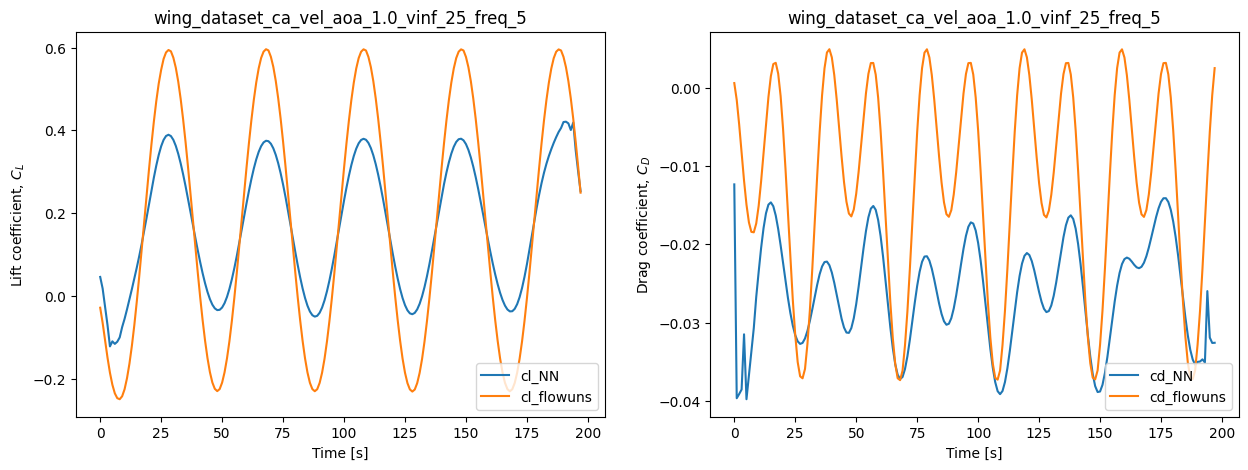

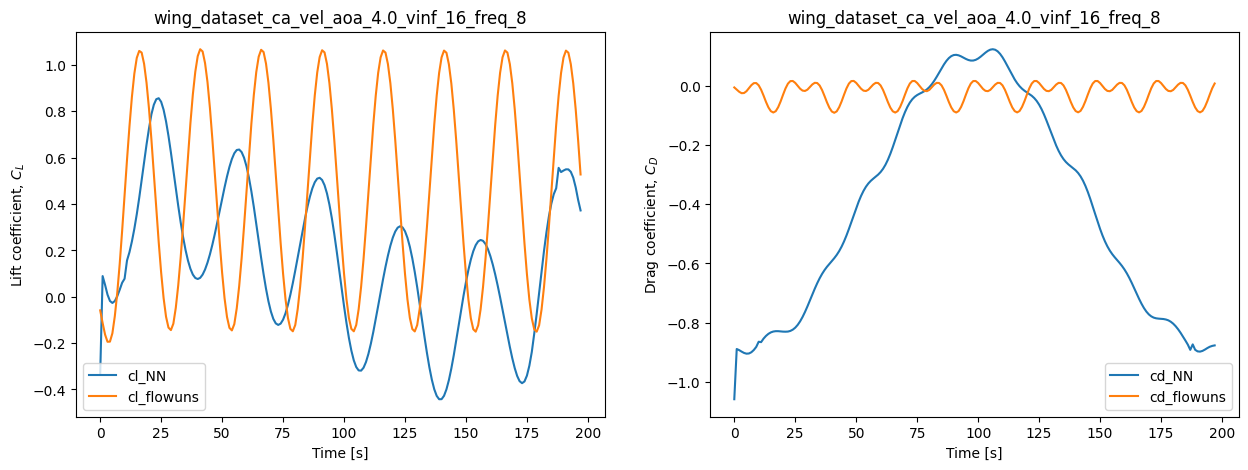

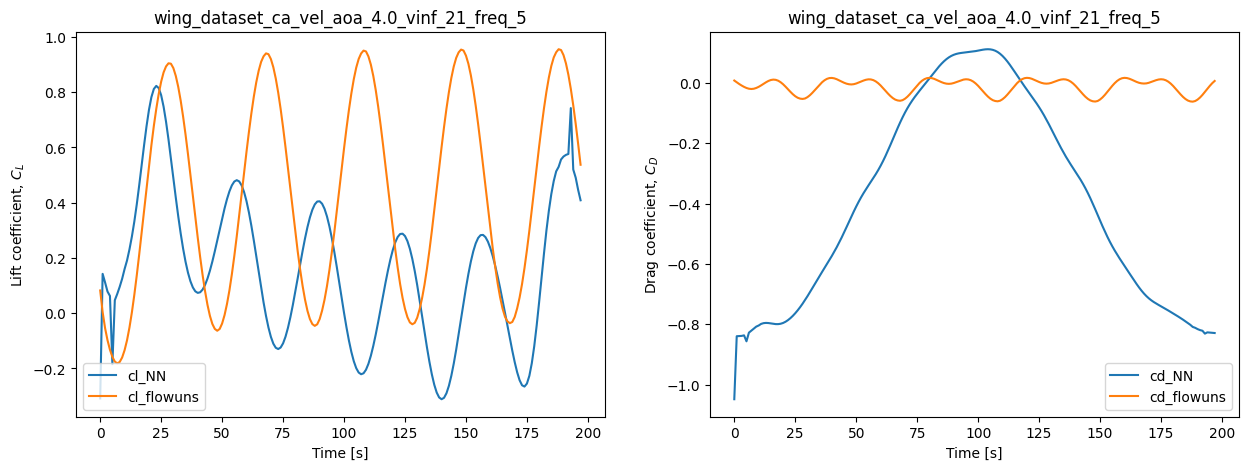

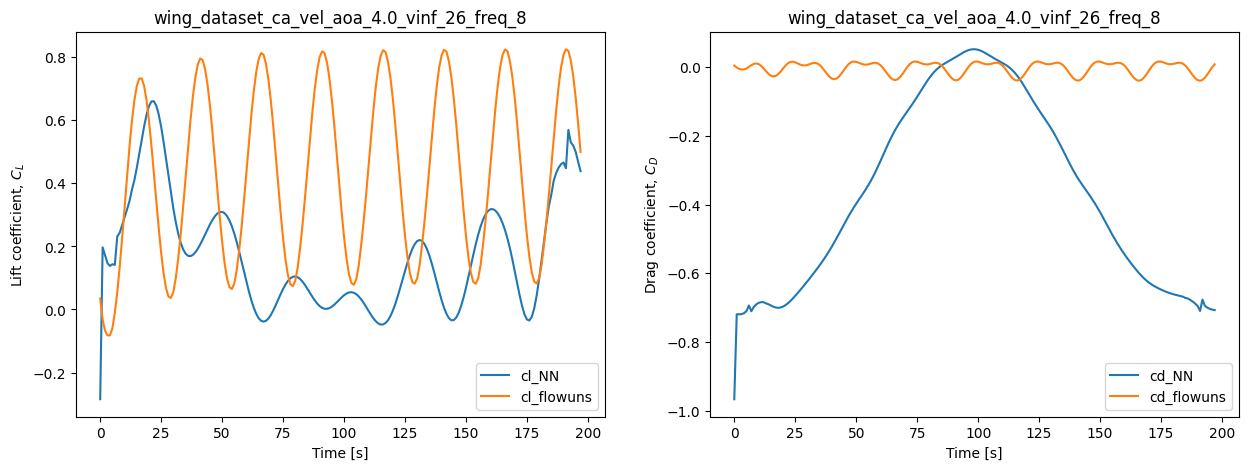

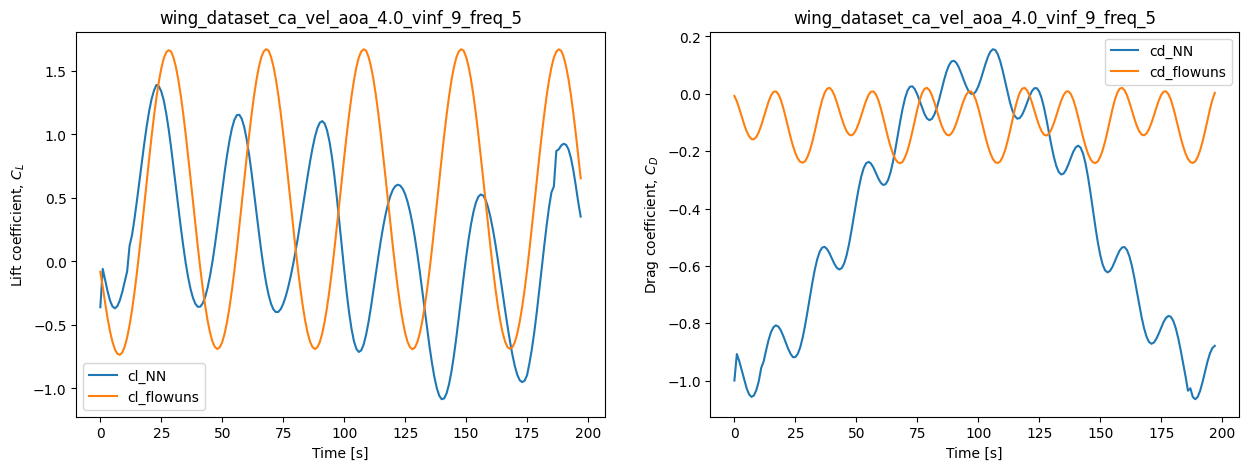

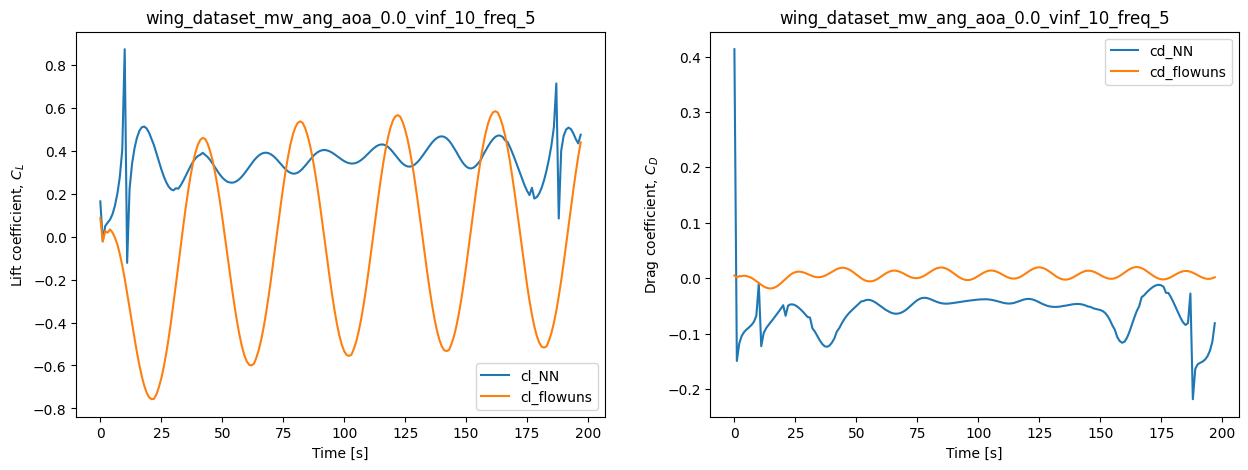

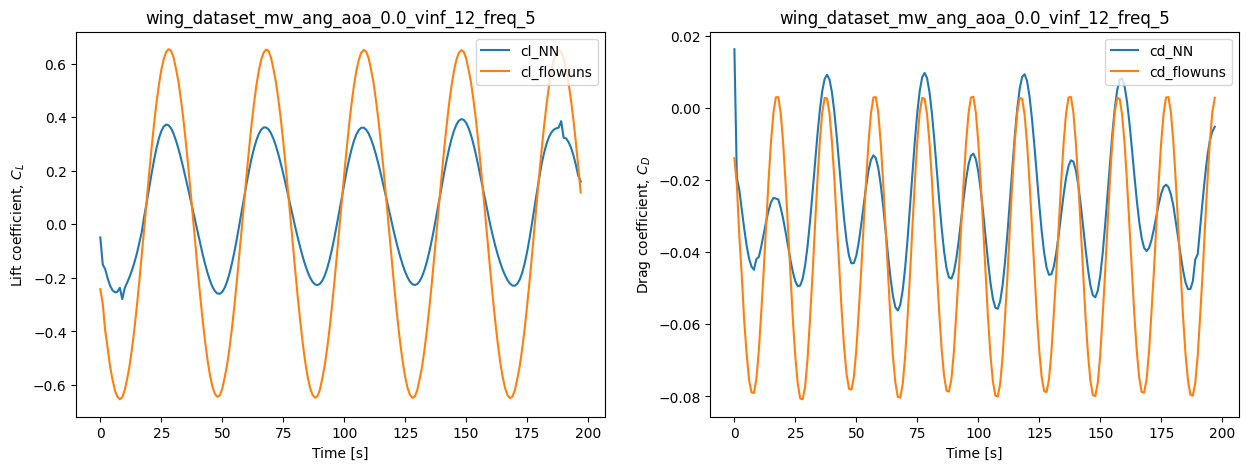

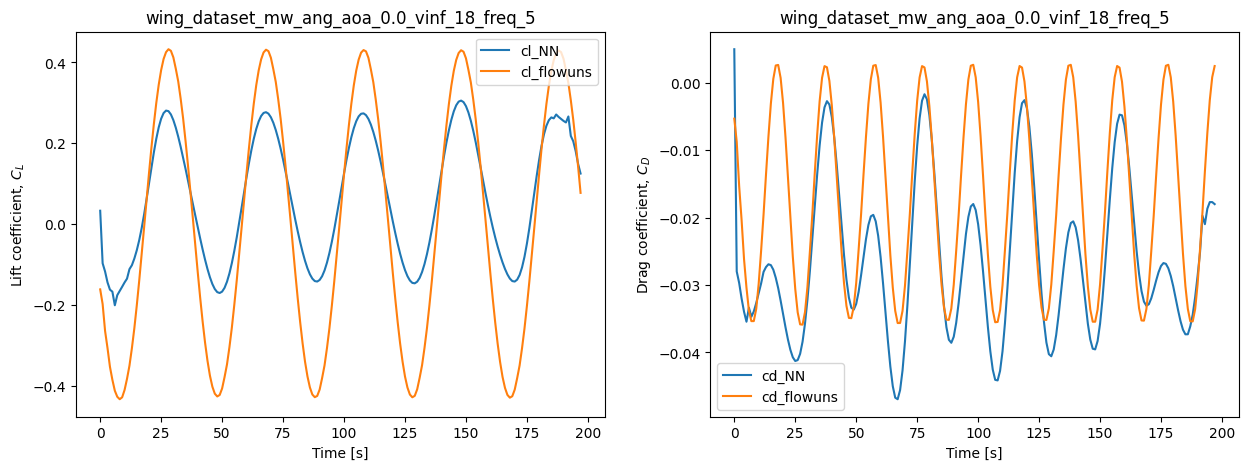

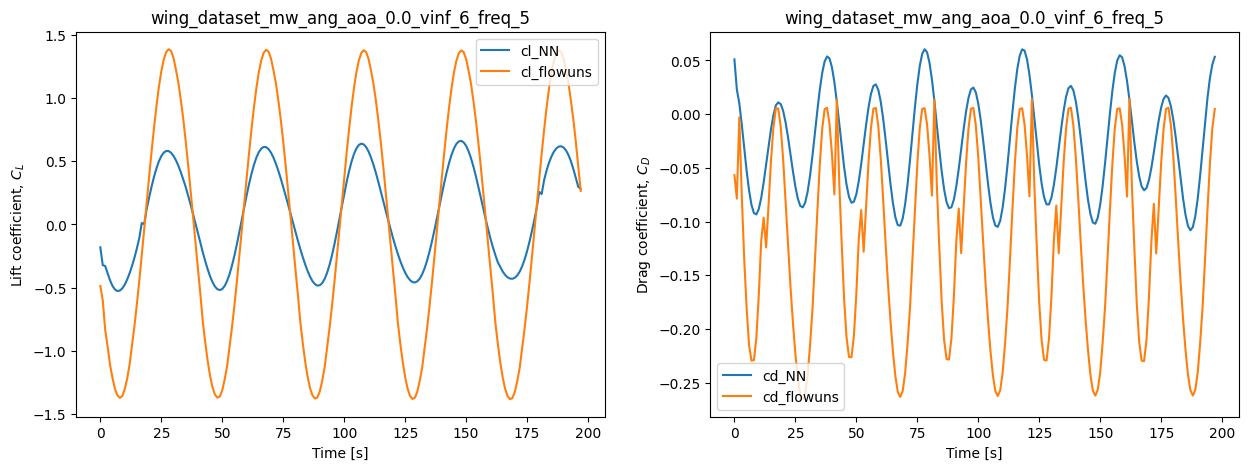

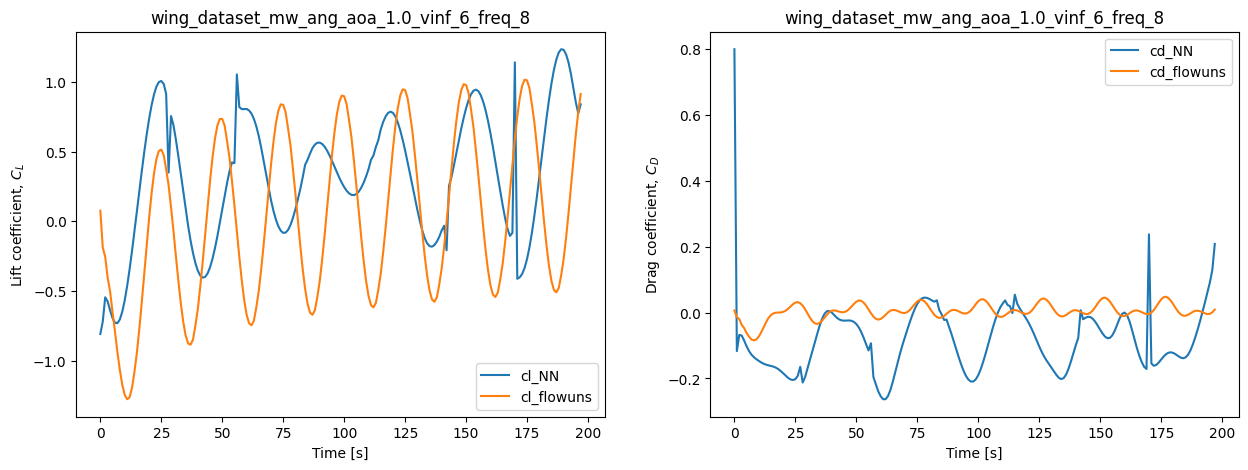

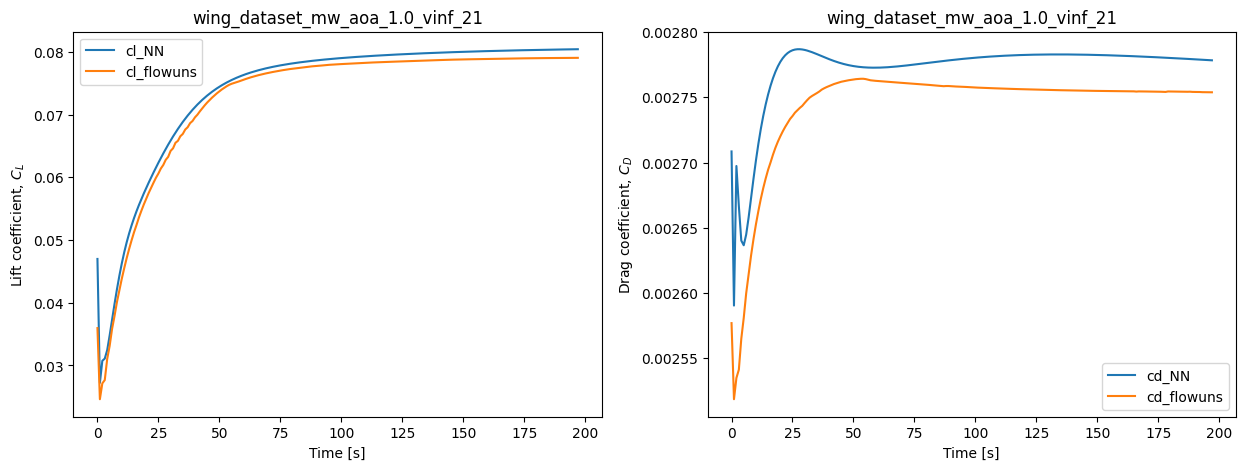

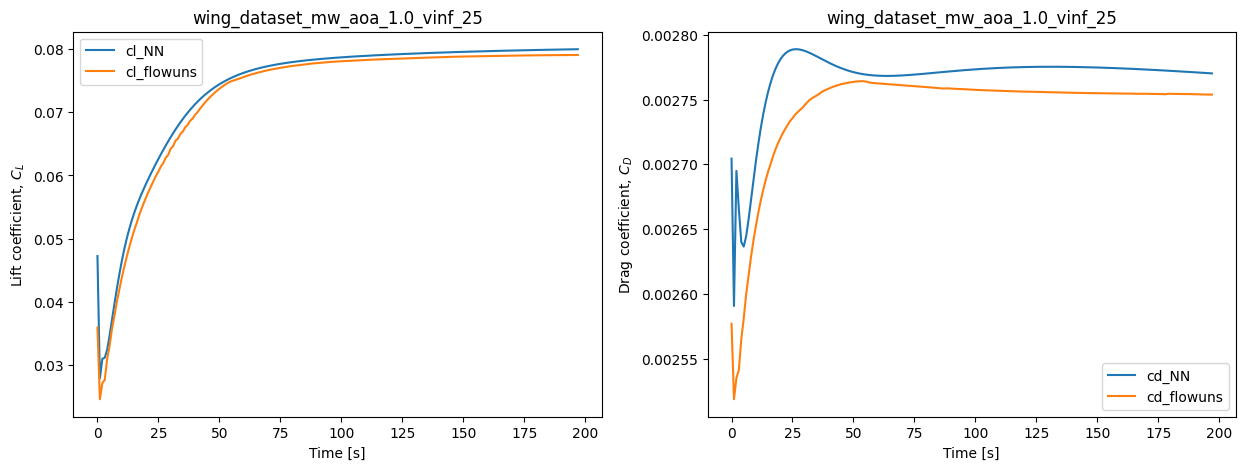

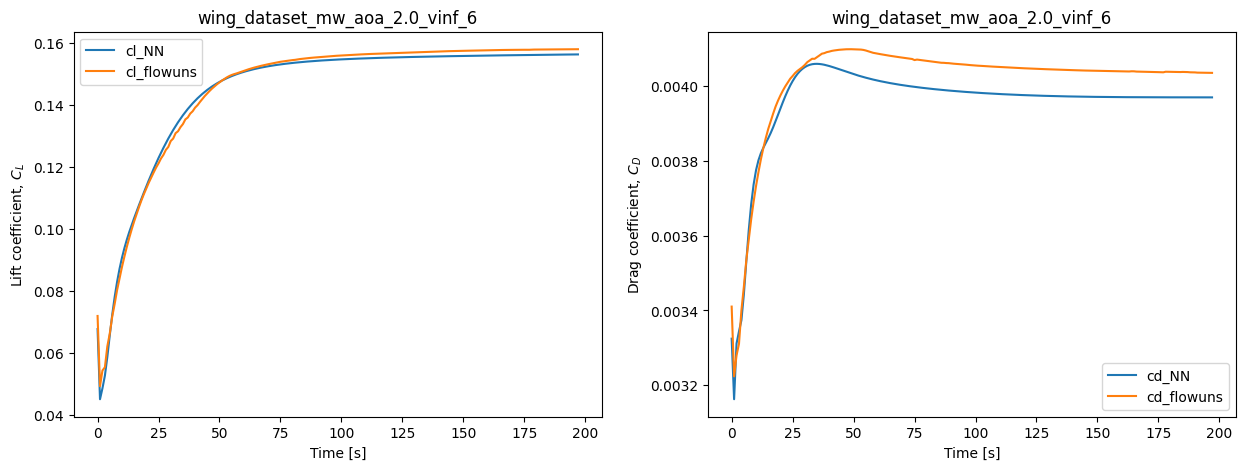

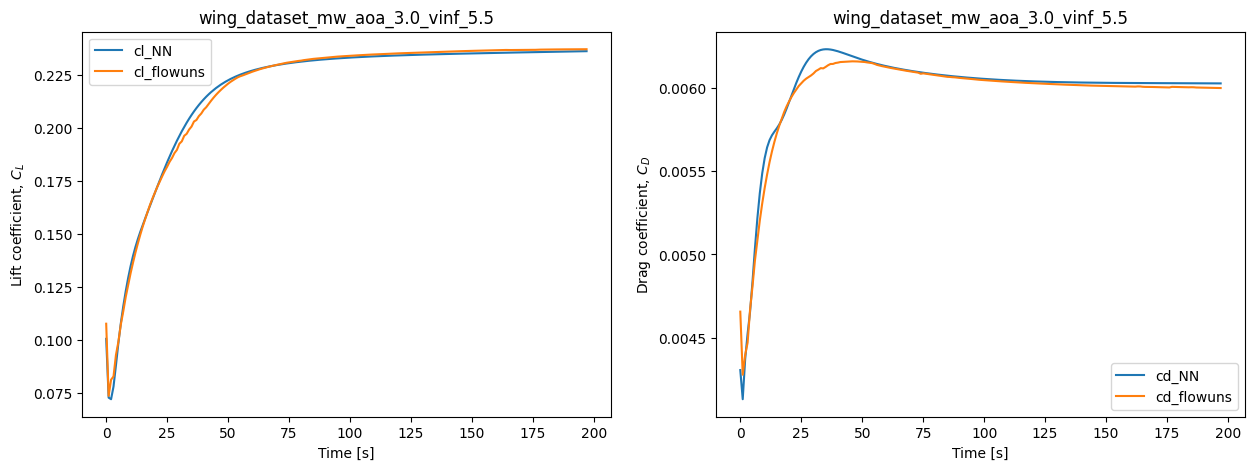

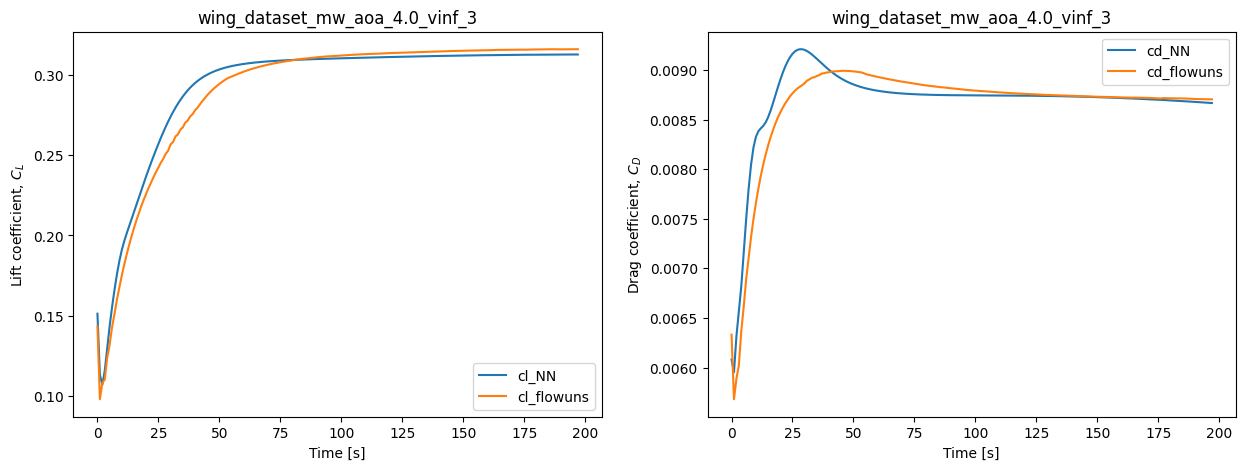

In [21]:
# Root directory where simulation subdirectories are stored
root_test_base = '../FLOWUnsteady_simulations/eMO_combined_dataset_test/'

for simulation_case in os.listdir(root_test_base):
    # Root directory where simulation subdirectories are stored
    root_dir_test_sim = root_test_base+simulation_case
  

    # Create the dataset with a subdirectory condition
    # dataset_test = PropellerDataset(root_dir_test_sim, alpha_test, J_test, theta_test, yaw_test, tilt_test, subdir_condition=subdir_condition)
    dataset_test = WingDataset(root_dir_test_sim, subdir_condition=subdir_condition)
    inputs_test, outputs_test = dataset_test[0:]

    model_type = dataset_test.get_variable('model_type')
    print("The selected model is - {}".format(model_type[0]))

    # Assuming your input tensor is named `input_tensor`
    input_tensor_test = inputs_test.squeeze(1)  # Remove the singleton dimension at index 1
    print("Input shape:", input_tensor_test.shape)  # Should print: torch.Size([6, 145, 7])


    if model_type[0] == 'static':
        print("Whats up")
        inputs_test_reshaped = input_tensor_test.reshape(-1, input_size_wing_stat)
        test_inputs_normalized = input_scaler_wing_stat.transform(inputs_test_reshaped.reshape(-1, input_size_wing_stat)).reshape(input_tensor_test.shape)
        test_inputs_tensor = torch.tensor(test_inputs_normalized, dtype=torch.float32).to(device)

        # Make predictions using the trained model
        with torch.no_grad():
            predicted_outputs = wing_model_static(test_inputs_tensor)

        # Convert the predictions back to numpy and inverse scale the outputs
        predicted_outputs = predicted_outputs.cpu().detach().numpy()  # Convert tensor to numpy array
        predicted_outputs_original_scale = output_scaler_wing_stat.inverse_transform(predicted_outputs.reshape(-1, output_size_wing_stat))

        # Reshape the predictions to match the original sequence structure
        predicted_outputs_original_scale = predicted_outputs_original_scale.reshape(input_tensor_test.shape[0], input_tensor_test.shape[1], output_size_wing_stat)
        predicted_outputs_original_scale = predicted_outputs_original_scale[0]

        # Model predicted values
        cl_test_NN = predicted_outputs_original_scale[:,0]
        cd_test_NN = predicted_outputs_original_scale[:,1]
    
    elif model_type[0] == 'dynamic_AOA':
        inputs_test_reshaped = input_tensor_test.reshape(-1, input_size_wing_dyn_ang)
        test_inputs_normalized = input_scaler_wing_dyn_ang.transform(inputs_test_reshaped.reshape(-1, input_size_wing_dyn_ang)).reshape(input_tensor_test.shape)
        test_inputs_tensor = torch.tensor(test_inputs_normalized, dtype=torch.float32).to(device)

        # Make predictions using the trained model
        with torch.no_grad():
            predicted_outputs = wing_model_dyn_ang(test_inputs_tensor)

        # Convert the predictions back to numpy and inverse scale the outputs
        predicted_outputs = predicted_outputs.cpu().detach().numpy()  # Convert tensor to numpy array
        predicted_outputs_original_scale = output_scaler_wing_dyn_ang.inverse_transform(predicted_outputs.reshape(-1, output_size_wing_dyn_ang))

        # Reshape the predictions to match the original sequence structure
        predicted_outputs_original_scale = predicted_outputs_original_scale.reshape(input_tensor_test.shape[0], input_tensor_test.shape[1], output_size_wing_dyn_ang)
        predicted_outputs_original_scale = predicted_outputs_original_scale[0]

        # Model predicted values
        fft_cl_nn_real = predicted_outputs_original_scale[:,0]
        fft_cd_nn_real = predicted_outputs_original_scale[:,2]
        
        fft_cl_nn_imag = predicted_outputs_original_scale[:,1]
        fft_cd_nn_imag = predicted_outputs_original_scale[:,3]

        fft_cl_fu_real, fft_cl_fu_imag = dataset_test.get_variable('fft_cl')
        fft_cd_fu_real, fft_cd_fu_imag = dataset_test.get_variable('fft_cd')

        complex_cl_nn = fft_cl_nn_real +1j * fft_cl_nn_imag
        cl_test_NN = ifft(complex_cl_nn)

        complex_cd_nn = fft_cd_nn_real +1j * fft_cd_nn_imag
        cd_test_NN = ifft(complex_cd_nn)
    
    elif model_type[0] == 'dynamic_vz':
        inputs_test_reshaped = input_tensor_test.reshape(-1, input_size_wing_dyn_vel)
        test_inputs_normalized = input_scaler_wing_dyn_vel.transform(inputs_test_reshaped.reshape(-1, input_size_wing_dyn_vel)).reshape(input_tensor_test.shape)
        test_inputs_tensor = torch.tensor(test_inputs_normalized, dtype=torch.float32).to(device)

        # Make predictions using the trained model
        with torch.no_grad():
            predicted_outputs = wing_model_dyn_vel(test_inputs_tensor)

        # Convert the predictions back to numpy and inverse scale the outputs
        predicted_outputs = predicted_outputs.cpu().detach().numpy()  # Convert tensor to numpy array
        predicted_outputs_original_scale = output_scaler_wing_dyn_vel.inverse_transform(predicted_outputs.reshape(-1, output_size_wing_dyn_vel))

        # Reshape the predictions to match the original sequence structure
        predicted_outputs_original_scale = predicted_outputs_original_scale.reshape(input_tensor_test.shape[0], input_tensor_test.shape[1], output_size_wing_dyn_vel)
        predicted_outputs_original_scale = predicted_outputs_original_scale[0]

        # Model predicted values

        fft_cl_nn_real = predicted_outputs_original_scale[:,0]
        fft_cd_nn_real = predicted_outputs_original_scale[:,2]
        
        fft_cl_nn_imag = predicted_outputs_original_scale[:,1]
        fft_cd_nn_imag = predicted_outputs_original_scale[:,3]

        fft_cl_fu_real, fft_cl_fu_imag = dataset_test.get_variable('fft_cl')
        fft_cd_fu_real, fft_cd_fu_imag = dataset_test.get_variable('fft_cd')

        complex_cl_nn = fft_cl_nn_real +1j * fft_cl_nn_imag
        cl_test_NN = ifft(complex_cl_nn)

        complex_cd_nn = fft_cd_nn_real +1j * fft_cd_nn_imag
        cd_test_NN = ifft(complex_cd_nn)

    
    # Load timesteps, CL and CD from FLOWUnsteady simualtions for comparison
    time_steps = dataset_test.get_variable('time')

    cl_test_flowuns = dataset_test.get_variable('CL')
    cd_test_flowuns = dataset_test.get_variable('CD')
    
    # Plot the results
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    # plt.plot(time_steps[0], ct_test_NN, label = 'ct_NN')
    # plt.plot(time_steps[0], (ct_test_flowuns[0]), label = 'ct_flowuns')
    plt.plot(cl_test_NN, label = 'cl_NN')
    plt.plot((cl_test_flowuns[0]), label = 'cl_flowuns')
    plt.xlabel('Time [s]')
    plt.ylabel('Lift coefficient, $C_L$')
    plt.title(simulation_case)
    plt.legend()

    # plt.figure()
    plt.subplot(1, 2, 2)
    # plt.plot(time_steps[0], cq_test_NN, label = 'cq_NN')
    # plt.plot(time_steps[0], cq_test_flowuns[0], label = 'cq_flowuns')
    plt.plot(cd_test_NN, label = 'cd_NN')
    plt.plot(cd_test_flowuns[0], label = 'cd_flowuns')
    plt.xlabel('Time [s]')
    plt.ylabel('Drag coefficient, $C_D$')
    plt.title(simulation_case)
    plt.legend()
    # break